#  Projet Bank_Py
---

Datascientest : Formation Continue Datascientist Octobre 2021

*   Ndeye-Yacine FALL
*   Louis PAVIE
*   Karima TOUMI



## 1) Contexte


---



L'objectif de ce projet *fil rouge* consiste à prédire le succès d'une campagne de Marketing bancaire visant à la souscription d'un contrat à terme.

Le support de ce projet est un *dataset* contenant les données d'une campagne de télémarketing réalisée auprès de ses clients par une banque Portugaise entre Mai 2008 et Novembre 2010.
Il existe plusieurs versions disponibles de ce dataset, de tailles et de compositions différentes. Parmi les 6 versions trouvées, nous avons préselectionnées les 2 versions contenant le plus de lignes (> 40 000 lignes), et finalement choisi la version avec données économiques (21 colonnes) qui nous paraissait plus intéressante que la version purement données bancaires (17 colonnes).

Pour mener à bien ce projet, notre démarche s'articulera en trois temps: 
* Nous effectuerons d'abord une analyse visuelle et statistique des données clients et du lien avec la variable cible (Y) souscription au dépôt à terme.

* Dans un deuxième temps, nous utiliserons les techniques du *Machine Learning* pour essayer de déterminer à l'avance si un client va souscrire ou non au dépot à terme proposé.

* Enfin à l'aide des techniques d'interprétabilité des modèles, nous tenterons d'expliquer à l'échelle d'un individu pourquoi il est plus susceptible de souscrire ou non.

**Références** : Données publiques utilisables dans le cadre de la recherche et l'éducation.

[Moro et al., 2011] *S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing.*

## 2) Configuration


---



Cette étape recouvre les importations de bibliothèques nécessaires au bon fonctionnement du notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api

%matplotlib inline
sns.set_theme

from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn import svm
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

from xgboost import XGBClassifier
from sklearn import ensemble
from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Pour fonctionner à partir de Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

## 3) Exploration des données


---


### A. Chargement des données depuis le Dataset



In [3]:
# pour fonctionner à partir de la plateforme CAAS
#df=pd.read_csv("/content/bank-additional-full.csv",sep=";")

# Pour fonctionner en local
df=pd.read_csv("bank-additional-full.csv",sep=";")

# Pour fonctionner à partir de Google Colab
#df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bank_Py /bank-additional-full.csv",sep=";")

### B. Découverte du DataSet

In [4]:
print('Shape :', df.shape)
df.head()

Shape : (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [11]:
df.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,Y_num
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,-1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,1
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,-1,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

* Le Dataset se compose de 41188 lignes pour 21 colonnes.
* Pas de colonne avec des valeurs non renseignées.
* Pas de colonne identifiant.
* Pas de colonne date.

Le document [Bank_Py-Rapport_Exploration_Données-VF.xlsx] contient les informations utiles à la compréhension des données de ce dataset.

Recherche de doublons parmi les lignes du dataset.

In [6]:
df.duplicated().sum()

12



*   Présence de 12 lignes en doublons
*   Suppression de ces lignes en doublons


In [7]:
df = df.drop_duplicates(keep = 'first')

Création d'un clone *'numérique'* de la variable cible pour les besoins de la matrice de corrélation.

In [8]:
df['Y_num'] = df['y']
df['Y_num'].replace({'no': 0}, inplace=True)
df['Y_num'].replace({'yes': 1}, inplace=True)
df['Y_num'].value_counts()

0    36537
1     4639
Name: Y_num, dtype: int64

In [9]:
df['pdays'].value_counts()
df['pdays'].replace({999: -1}, inplace=True)

### C. Analyse visuelle et statistique


#### Variables Quantitatives


##### Analyse de la distribution des variables quantitatives

In [10]:
df.describe().round()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,Y_num
count,41176.0,41176.0,41176.0,41176.0,41176.0,41176.0,41176.0,41176.0,41176.0,41176.0,41176.0
mean,40.0,258.0,3.0,-1.0,0.0,0.0,94.0,-41.0,4.0,5167.0,0.0
std,10.0,259.0,3.0,2.0,0.0,2.0,1.0,5.0,2.0,72.0,0.0
min,17.0,0.0,1.0,-1.0,0.0,-3.0,92.0,-51.0,1.0,4964.0,0.0
25%,32.0,102.0,1.0,-1.0,0.0,-2.0,93.0,-43.0,1.0,5099.0,0.0
50%,38.0,180.0,2.0,-1.0,0.0,1.0,94.0,-42.0,5.0,5191.0,0.0
75%,47.0,319.0,3.0,-1.0,0.0,1.0,94.0,-36.0,5.0,5228.0,0.0
max,98.0,4918.0,56.0,27.0,7.0,1.0,95.0,-27.0,5.0,5228.0,1.0


* L'age moyen du portefeuille est de 40 ans.
* 50% du portefeuille a un age compris entre 32 ans et 47 ans.
* La durée du contact est en moyenne de 4 minutes et 18 secondes.
* Pour la campagne en cours, chaque client a été contacté en moyenne entre 2 et 3 fois.
* 50% des clients ont été contactés entre 1 ou 3 fois.
* Le nombre de contact maximum qui est de 56 nous semble aberrant.
* Vu les statistiques, la variable pdays ne semble pas exploitable, nous pourrons la retirer par la suite.
* La majorité des clients est contacté pour la première fois lors de cette campagne.
* Sur la période d'observation, les indicateurs économiques sont relativement stables hormis l'Euribor et la variation du taux d'emploi.

##### Visualisation via 'heatmap' de la corrélation entre les variables quantitatives

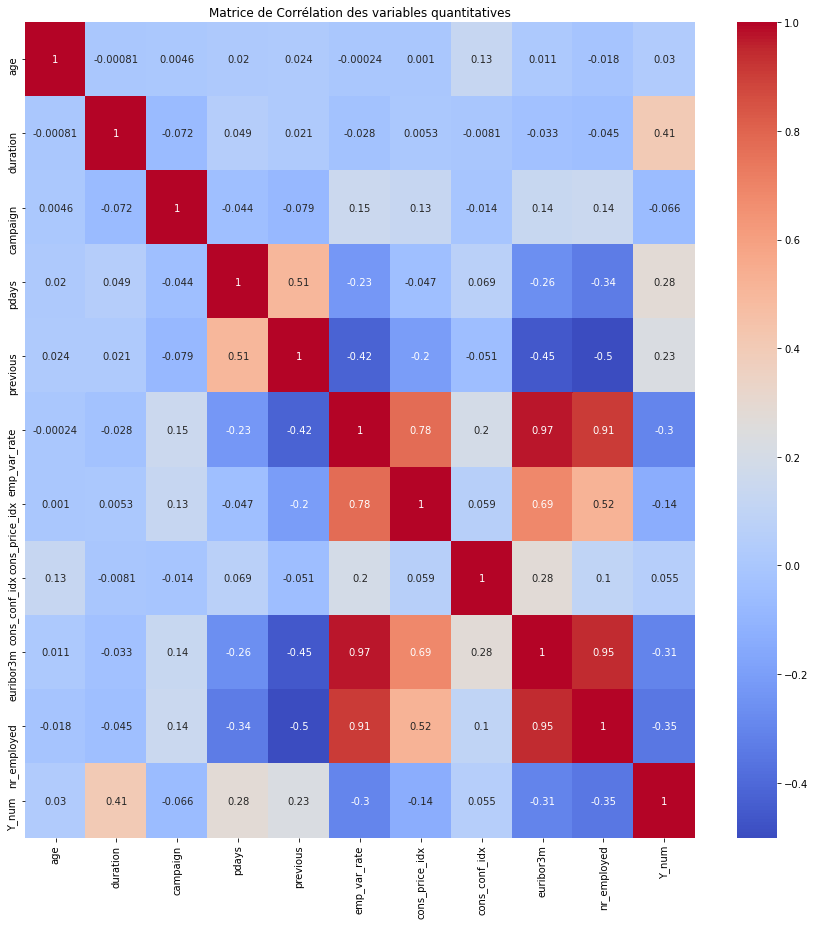

In [11]:
cor = df.corr()

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cor, annot=True, ax=ax, cmap='coolwarm')
plt.title('Matrice de Corrélation des variables quantitatives');

La matrice de corrélation entre les variables quantitatives permet de constater de manière générale des corrélations assez faibles entre les variables. Toutefois nous pouvons constater des corrélations assez fortes pour les variables économiques entre elles, ce qui est logique.

En ce qui concerne la corrélation avec la variable cible, c'est la durée de l'appel qui obtient le coefficient de corrélation le plus important (0,41).
Suivi par le nombre de jours depuis le dernier contact (0,28) et le nombre de contact (0,23).
Les coefficients de corrélations négatif entre la variable cible et les variables économiques s'expliquent par l'aspect 'refuge' du dépôt à terme.  

##### Visualisation de la distribution de la variable 'Age', en fonction du résultat (Y/N) de souscription.

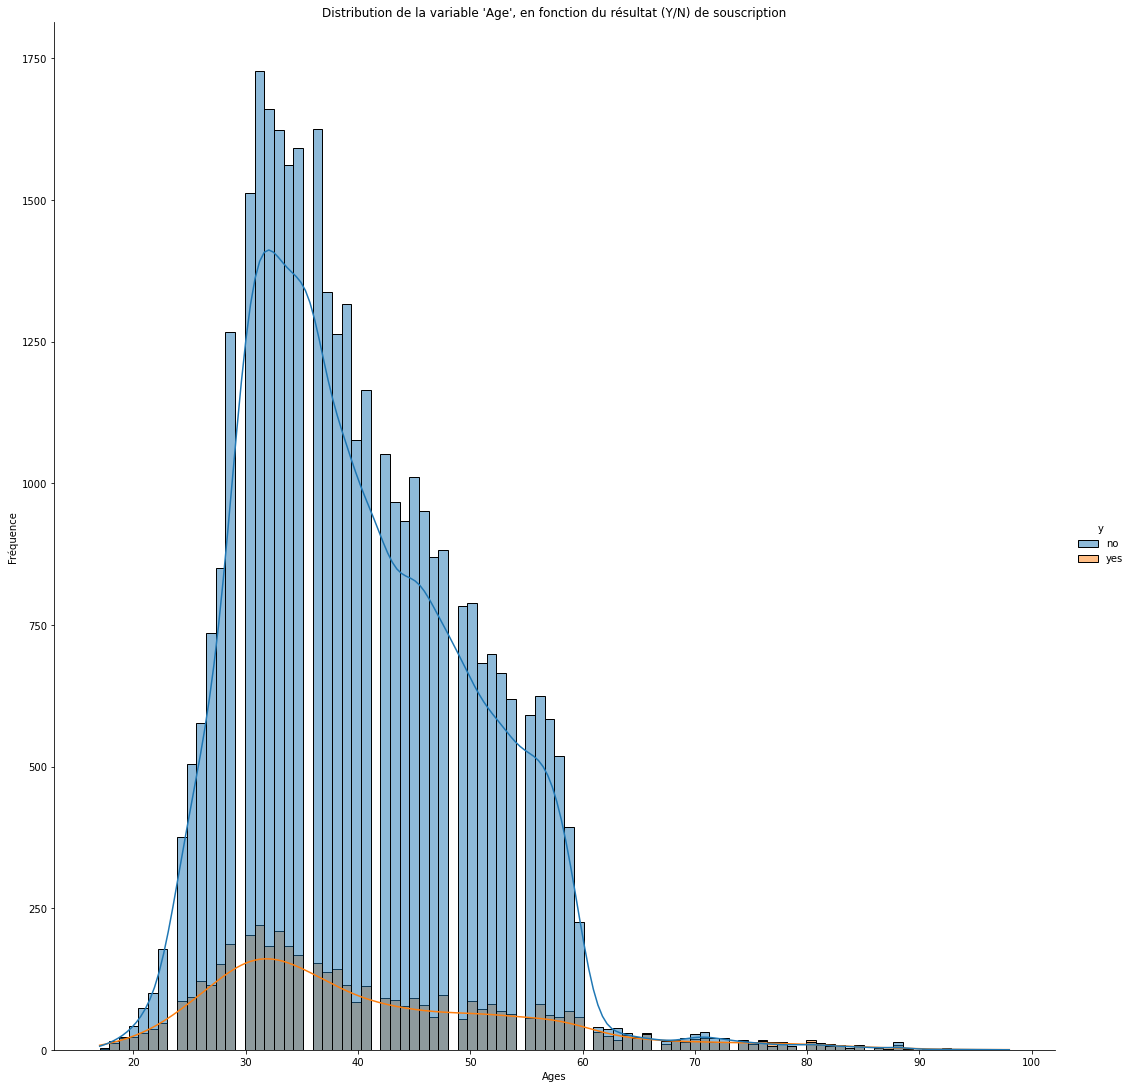

In [12]:
sns.displot(data=df, x="age", hue="y", kde= True, height=15)
plt.xlabel('Ages')
plt.ylabel("Fréquence")
plt.title("Distribution de la variable 'Age', en fonction du résultat (Y/N) de souscription");

Cette visualisation de la distribution de la variable 'age' permet de constater que la population ciblée est majoritairement 'jeune' et d'age inférieur à 60 ans.
Nous pouvons constater aussi que la population d'age supérieur à 60 ans est beaucoup plus apétente à la souscrition du produit dépôt à terme.  

##### Visualisation de la distribution de la variable 'Duration', en fonction du résultat (Y/N) de souscription.

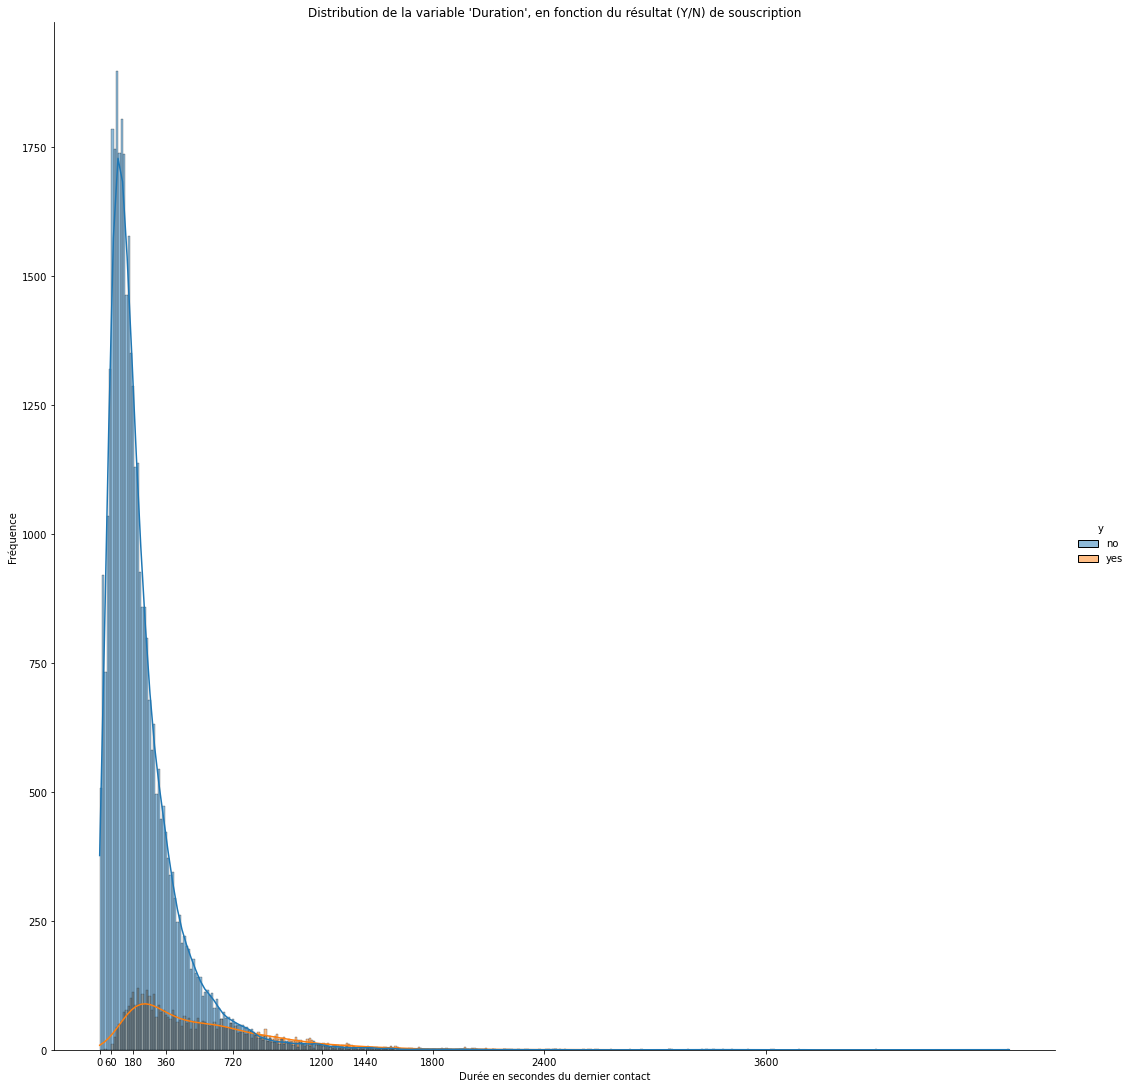

In [13]:
sns.displot(data=df, x="duration", hue="y", kde= True, height=15)
# découpage en plages 'minutes compatibles' des durées en secondes 
plt.xticks([0,60,180,360,720,1200,1440,1800,2400,3600])
plt.xlabel('Durée en secondes du dernier contact')
plt.ylabel("Fréquence")
plt.title("Distribution de la variable 'Duration', en fonction du résultat (Y/N) de souscription");

Nous pouvons constater que : 
* la majorité des appels durent entre 1 et 6 minutes
* les appels de moins de 1 minutes sont improductifs
* les appels entre 3 et 12 minutes sont souvent productifs
* les appels entre 12 et 24 minutes, sont très productifs, mais peu nombreux. 

##### Visualisation de la distribution de la variable 'Campaign', en fonction du résultat (Y/N) de souscription.

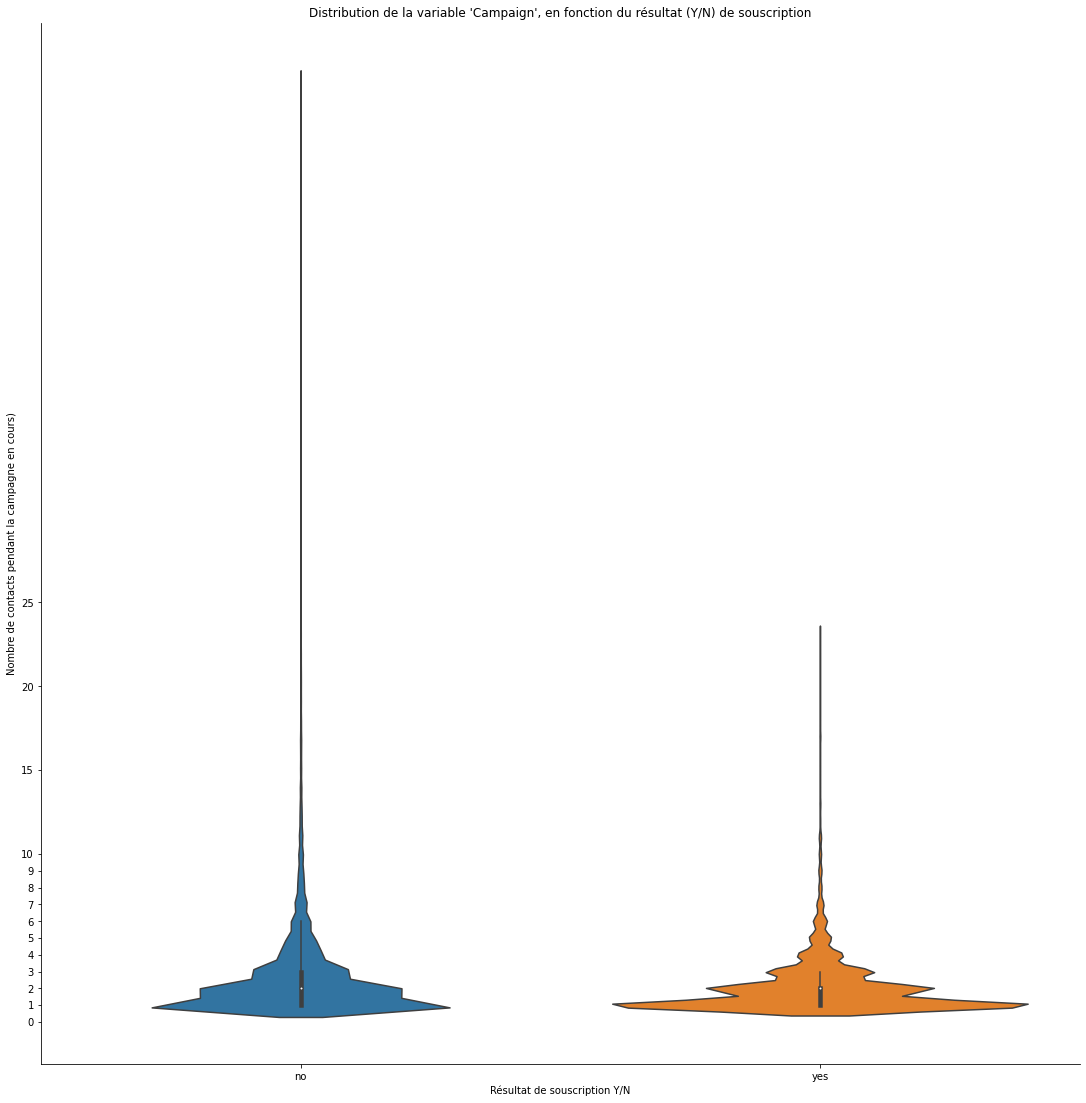

In [14]:
sns.catplot(x='y', y='campaign', kind='violin', data=df, height=15)
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,15,20,25])
plt.xlabel('Résultat de souscription Y/N')
plt.ylabel("Nombre de contacts pendant la campagne en cours)")
plt.title("Distribution de la variable 'Campaign', en fonction du résultat (Y/N) de souscription");

In [15]:
pd.crosstab(df.y, df.campaign, normalize = 0)

campaign,1,2,3,4,5,6,7,8,9,10,...,33,34,35,37,39,40,41,42,43,56
y,,,,,,,,,,,,,,,,,,,,,
no,0.419712,0.256097,0.130443,0.065714,0.040480,0.024742,0.016175,0.010483,0.007280,0.005830,...,0.000109,0.000082,0.000137,0.000027,0.000027,0.000055,0.000027,0.000055,0.000055,0.000027
yes,0.495581,0.261048,0.123734,0.053675,0.025868,0.016167,0.008191,0.003665,0.003665,0.002587,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Les personnes qui ont souscrits sont près de 50% à le faire au premier contact, cependant, les personnes qui ont été contactées plusieurs foisau cours de cette campagne sont encore susceptibles de souscrire même si cette tendance diminue après le troisiemme contact et devient négligeable après le cinquième contact (effet de lassitude ?).

##### Visualisation de la variable 'pdays', en fonction du résultat (Y/N) de souscription.

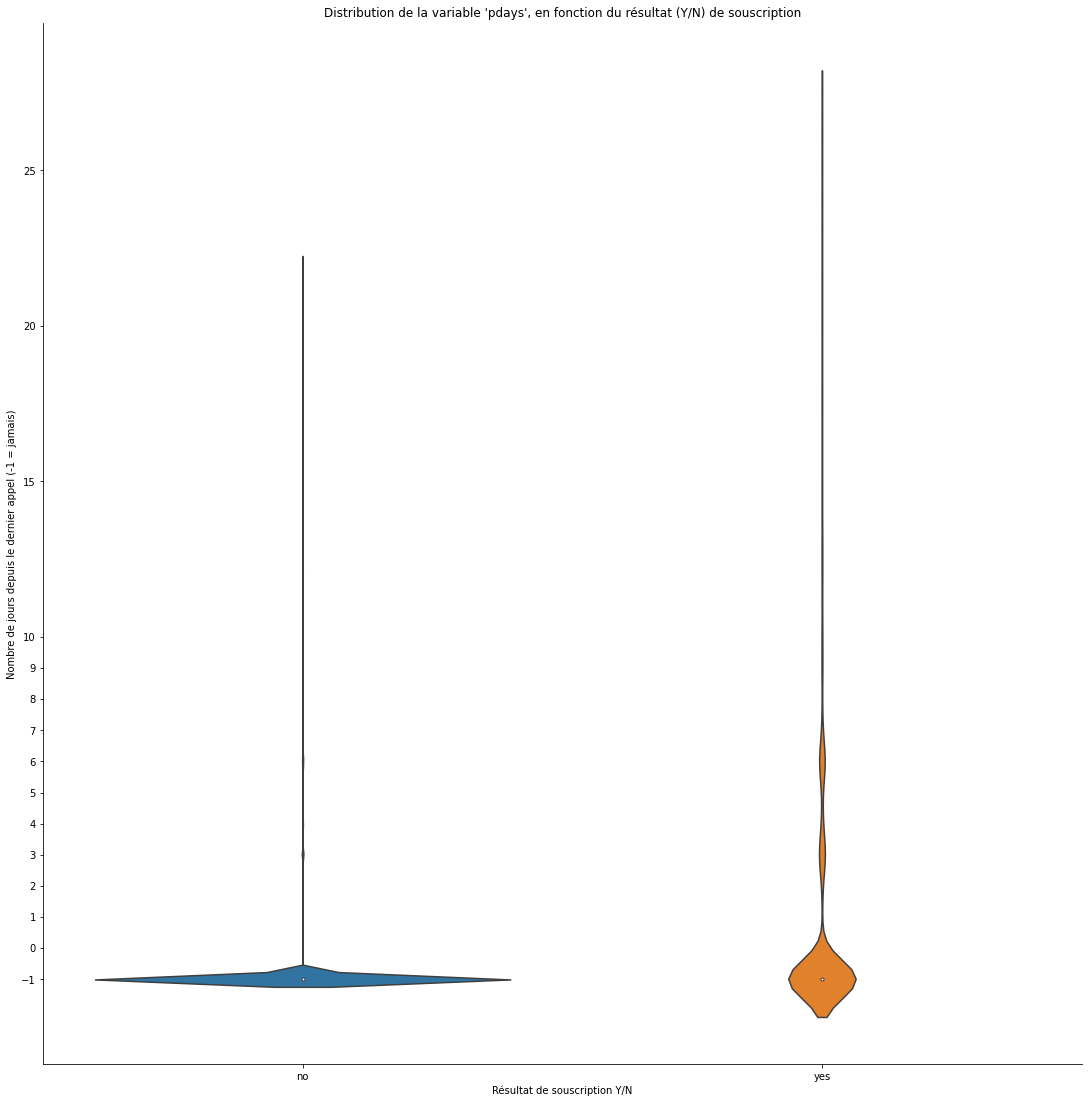

In [16]:
sns.catplot(x='y', y='pdays', kind='violin', data=df, height=15)
plt.yticks([-1,0,1,2,3,4,5,6,7,8,9,10,15,20,25])
plt.xlabel('Résultat de souscription Y/N')
plt.ylabel("Nombre de jours depuis le dernier appel (-1 = jamais)")
plt.title("Distribution de la variable 'pdays', en fonction du résultat (Y/N) de souscription");

In [17]:
pd.crosstab(df.y, df.pdays, normalize = 0)

pdays,-1,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,25,26,27
y,,,,,,,,,,,,,,,,,,,,,
no,0.985002,0.000137,0.000493,0.000657,0.003859,0.001505,0.000465,0.003366,0.000547,0.000164,...,0.000137,0.000164,0.000082,0.000055,0.000027,0.000000,0.000027,0.000000,0.000000,0.000000
yes,0.791550,0.002156,0.001725,0.007976,0.064238,0.013581,0.006251,0.062298,0.008623,0.002587,...,0.001293,0.000431,0.000862,0.000216,0.000000,0.000431,0.000431,0.000216,0.000216,0.000216


La majorité des non souscriptions (98,5%) se produisent pour des personnes qui non pas été recontactées après une campagne antérieure, c'est à dire pour des personnes primo-contactées. Par contre pour les souscriptions, elles sont réalisées à 79% par des primo-contactées, puis le reste des souscriptions par les personnes au fur et à mesure des recontacts mêmes si les volumes représentés sont très faibles.  

##### Visualisation de la variable 'previous', en fonction du résultat (Y/N) de souscription.

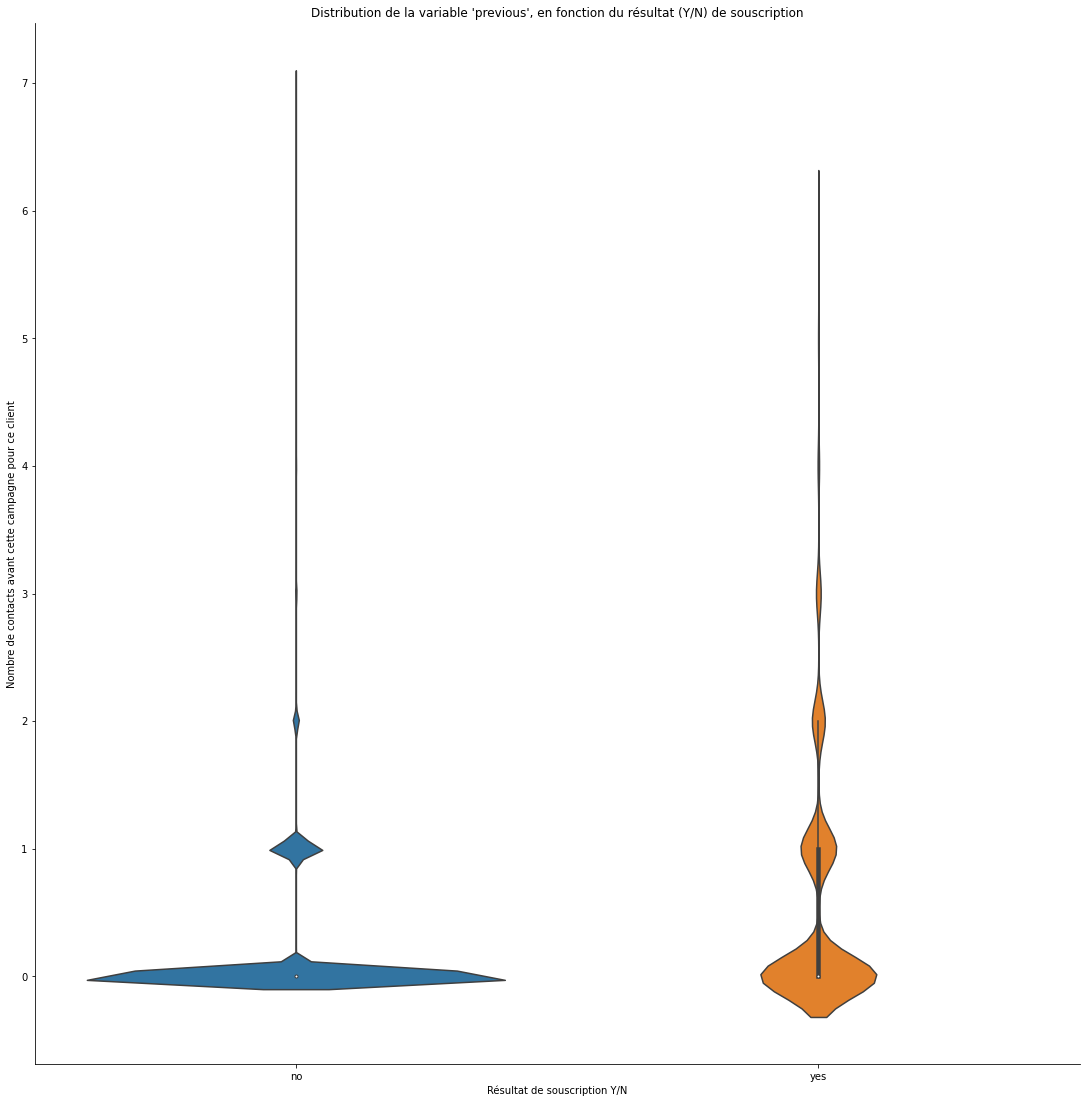

In [18]:
sns.catplot(x='y', y='previous', kind='violin', data=df, height=15)

plt.xlabel('Résultat de souscription Y/N')
plt.ylabel("Nombre de contacts avant cette campagne pour ce client")
plt.title("Distribution de la variable 'previous', en fonction du résultat (Y/N) de souscription");

In [19]:
pd.crosstab(df.y, df.previous, normalize = 0)

previous,0,1,2,3,4,5,6,7
y,,,,,,,,
no,0.887073,0.098366,0.011057,0.002409,0.000876,0.000137,0.000055,0.000027
yes,0.676870,0.208450,0.075447,0.027592,0.008191,0.002802,0.000647,0.000000


La trés grande majorité des personnes n'ont pas été contactées avant la campagne en cours (previous = 0). Cependant, les personnes qui ont été recontactées sont susceptibles de souscrire même si cette tendance diminue après le troisiemme contact (effet de lassitude ?).

#### Variables Qualitatives

##### Visualisation de la variable 'Job', en fonction du résultat (Y/N) de souscription

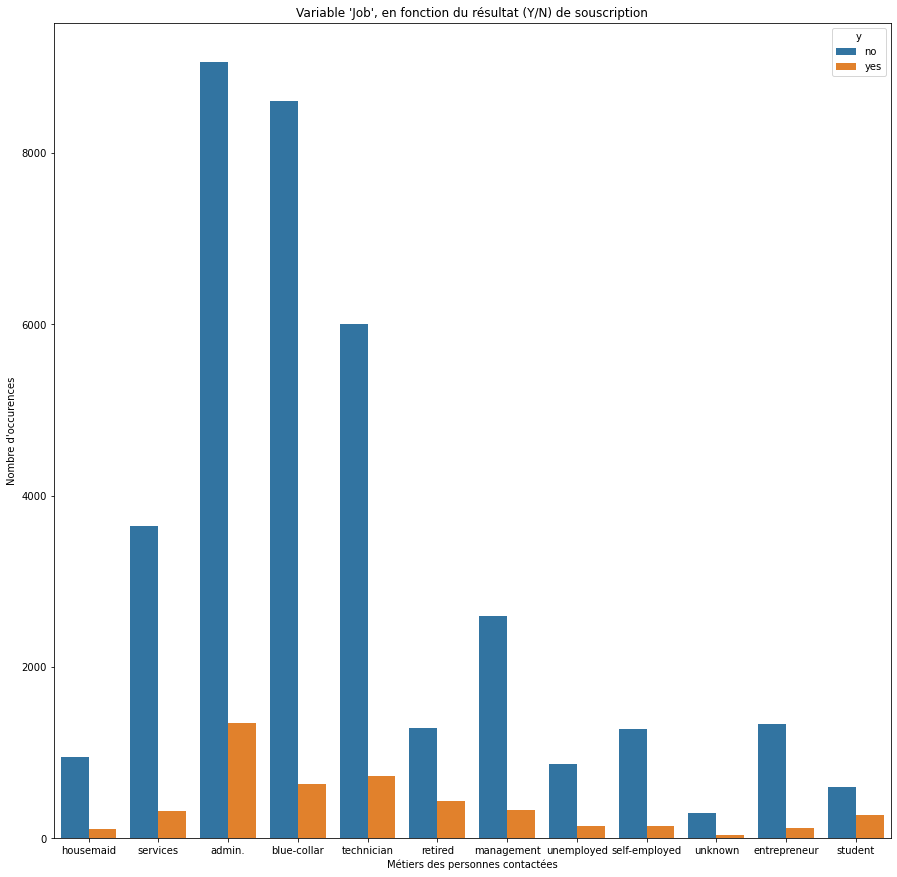

In [20]:
plt.figure(figsize = (15, 15))
sns.countplot(x='job', data=df, hue = 'y')
plt.xlabel('Métiers des personnes contactées')
plt.ylabel("Nombre d'occurences")
plt.title("Variable 'Job', en fonction du résultat (Y/N) de souscription");

In [21]:
pd.crosstab(df.y, df.job, normalize = 0)

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
y,,,,,,,,,,,,
no,0.248187,0.235788,0.036456,0.026111,0.071051,0.035142,0.034814,0.099735,0.016422,0.164463,0.023811,0.008019
yes,0.291227,0.137530,0.026730,0.022850,0.070705,0.093555,0.032119,0.069627,0.059280,0.157362,0.031041,0.007976


Les employés de bureau, les ouvriers et les techniciens sont les plus représentés parmi les personnes contactées, et c'est parmi leurs rangs que l'on retrouve la plus forte proportion de ceux qui ont souscrit (employés de bureau 29%, techniciens 16% et ouvriers 14%).   

In [22]:
pd.crosstab(df.y, df.job, normalize = 1)

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
y,,,,,,,,,,,,
no,0.870333,0.931049,0.914835,0.9,0.887825,0.747381,0.895144,0.918578,0.685714,0.891675,0.857988,0.887879
yes,0.129667,0.068951,0.085165,0.1,0.112175,0.252619,0.104856,0.081422,0.314286,0.108325,0.142012,0.112121


Par contre quand nous étudions la proportion de souscription par modalité, nous le trio étudiants (31%), retraités (25%), et chômeurs (14%) ressort en tête, ce qui pourrait sembler contre-intuitif mais peut s'expliquer par un meilleur ciblage dans ces catégories et sans doute aussi par un effet de nombre pour les catégories les plus représentées.

##### Visualisation de la variable 'Marital', en fonction du résultat (Y/N) de souscription

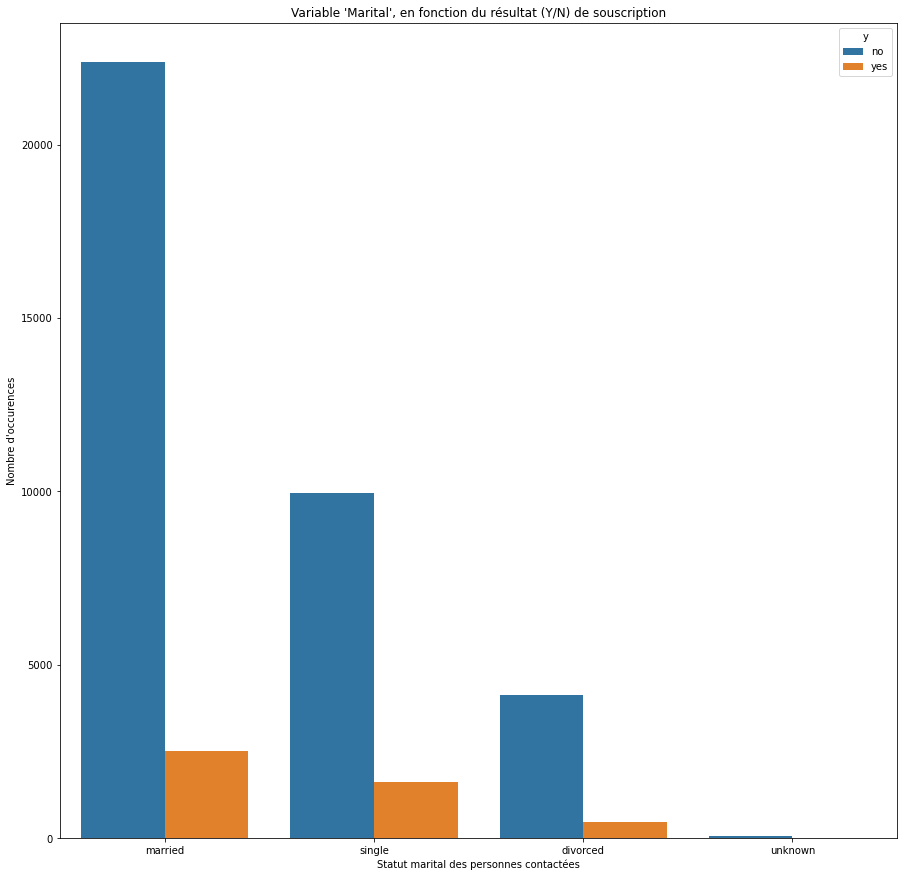

In [23]:
plt.figure(figsize = (15, 15))
sns.countplot(x='marital', data=df, hue = 'y')
plt.xlabel('Statut marital des personnes contactées')
plt.ylabel("Nombre d'occurences")
plt.title("Variable 'Marital', en fonction du résultat (Y/N) de souscription");

In [24]:
pd.crosstab(df.y, df.marital, normalize = 0)

marital,divorced,married,single,unknown
y,,,,
no,0.113173,0.612803,0.272162,0.001861
yes,0.102608,0.545592,0.349213,0.002587


Les personnes marriées sont les plus représentés parmi les personnes contactées, et c'est parmi leurs rangs que l'on retrouve la plus forte proportion de ceux qui ont souscrit (54,5%), suivi par les célibataires (35%).

In [25]:
pd.crosstab(df.y, df.marital, normalize = 1)

marital,divorced,married,single,unknown
y,,,,
no,0.896769,0.898439,0.85991,0.85
yes,0.103231,0.101561,0.14009,0.15


Par contre quand nous étudions la proportion de souscription par modalité, ce sont les célibataires qui soucrivent le plus (14%).

##### Visualisation de la variable 'Education', en fonction du résultat (Y/N) de souscription

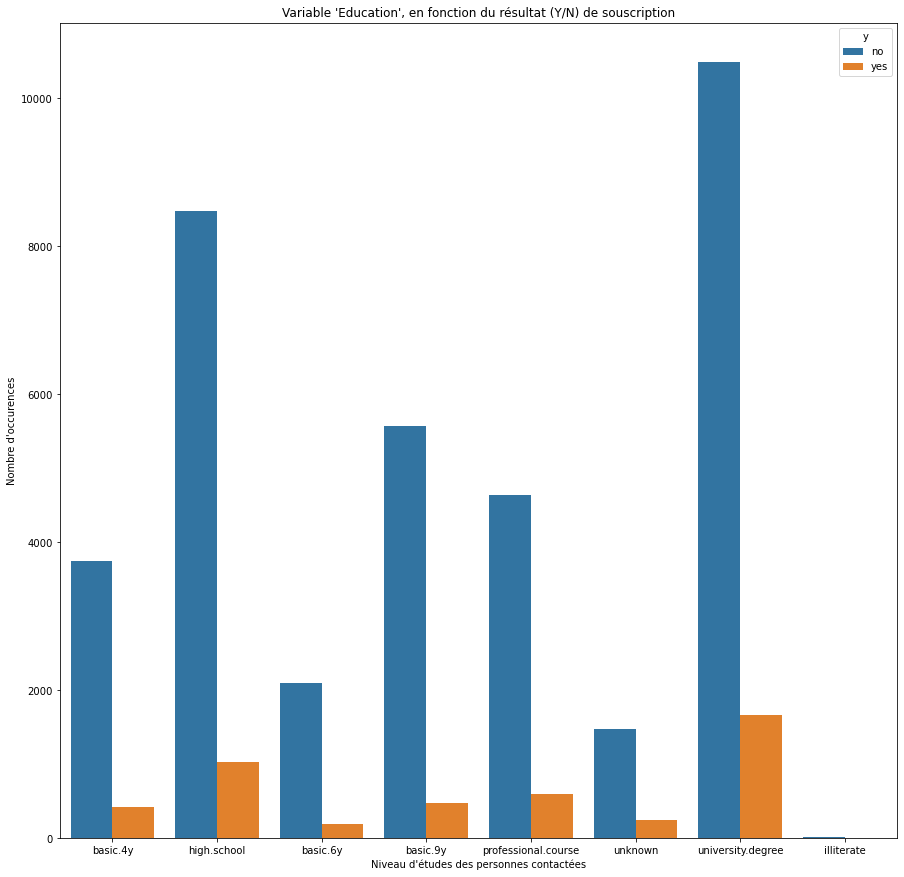

In [26]:
plt.figure(figsize = (15, 15))
sns.countplot(x='education', data=df, hue = 'y')
plt.xlabel("Niveau d'études des personnes contactées")
plt.ylabel("Nombre d'occurences")
plt.title("Variable 'Education', en fonction du résultat (Y/N) de souscription");

In [27]:
pd.crosstab(df.y, df.education, normalize = 0)

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
y,,,,,,,,
no,0.102581,0.057558,0.152503,0.232121,0.000383,0.127131,0.287243,0.040480
yes,0.092261,0.040526,0.101962,0.222246,0.000862,0.128260,0.359776,0.054106


Les personnes les plus représentés parmi les personnes contactées sont celles qui ont un diplome universitaire, suivi de celles qui suivi leur scolarité dans une 'grande école'. C'est parmi leurs rangs que l'on retrouve la plus forte proportion de ceux qui ont souscrit (36%) et (22%).

In [28]:
pd.crosstab(df.y, df.education, normalize = 1)

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
y,,,,,,,,
no,0.89751,0.91794,0.921754,0.891611,0.777778,0.88645,0.862792,0.854913
yes,0.10249,0.08206,0.078246,0.108389,0.222222,0.11355,0.137208,0.145087


22% des illettrés souscrivent un dépôt à terme, ce bon score est à rapporter au trés faible effectif de ceux-ci, et n'est pas significatif. 

##### Visualisation de la variable 'Default', en fonction du résultat (Y/N) de souscription

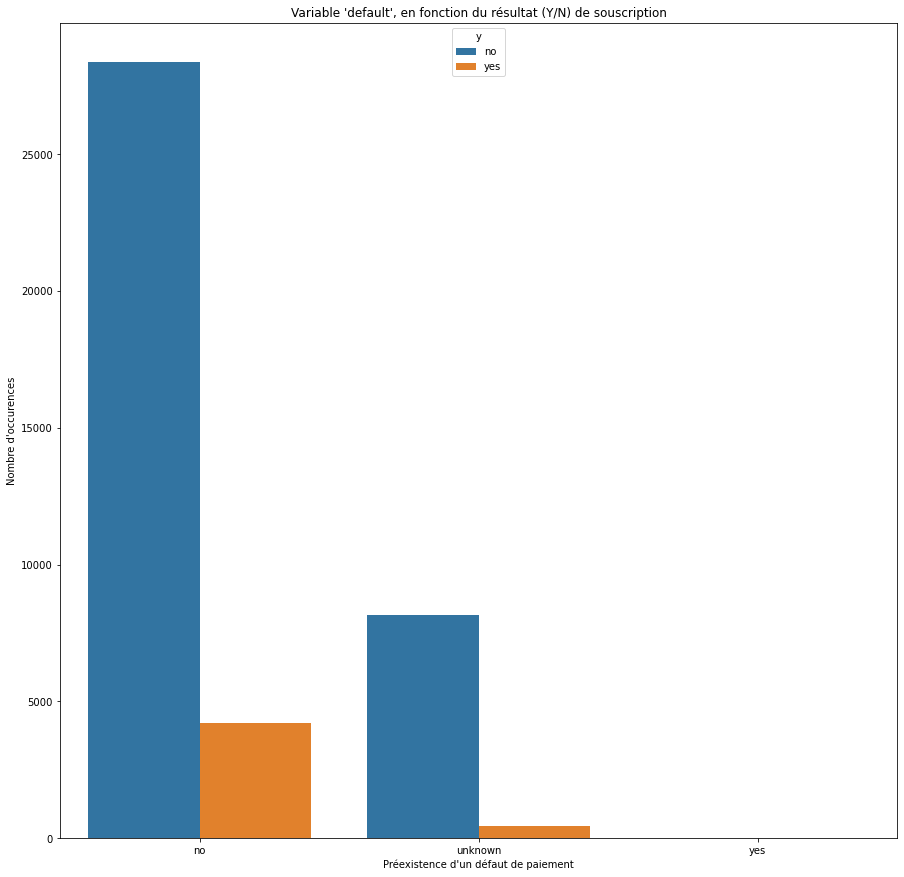

In [29]:
plt.figure(figsize = (15, 15))
sns.countplot(x='default', data=df, hue = 'y')
plt.xlabel("Préexistence d'un défaut de paiement")
plt.ylabel("Nombre d'occurences")
plt.title("Variable 'default', en fonction du résultat (Y/N) de souscription");

In [30]:
pd.crosstab(df.y, df.default, normalize = 0)

default,no,unknown,yes
y,,,
no,0.776774,0.223144,0.000082
yes,0.904505,0.095495,0.000000


Sans surprise la trés grande majorité des personnes contactées n'ont pas connues de défaut de paiement. Et aucune des quelques personnes ayant un défaut de paiement n'a souscrit (clause exclusive ?).

##### Visualisation de la variable 'Housing', en fonction du résultat (Y/N) de souscription

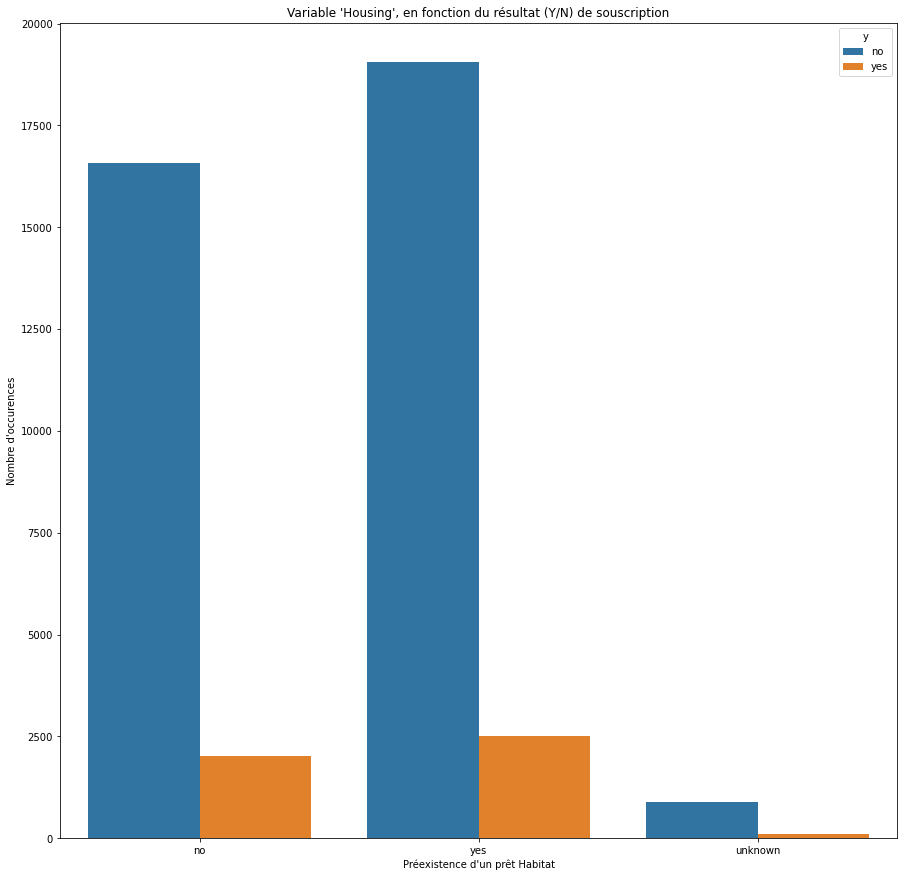

In [31]:
plt.figure(figsize = (15, 15))
sns.countplot(x='housing', data=df, hue = 'y')
plt.xlabel("Préexistence d'un prêt Habitat")
plt.ylabel("Nombre d'occurences")
plt.title("Variable 'Housing', en fonction du résultat (Y/N) de souscription");

In [32]:
pd.crosstab(df.y, df.housing, normalize = 0)

housing,no,unknown,yes
y,,,
no,0.454060,0.024167,0.521772
yes,0.436516,0.023065,0.540418


Nous constatons une légère pré-éminence des détenteurs de prêt Habitat, tant en nombre de personnes qu'en proportion de ceux qui ont souscrits (54%).

##### Visualisation de la variable 'Loan', en fonction du résultat (Y/N) de souscription

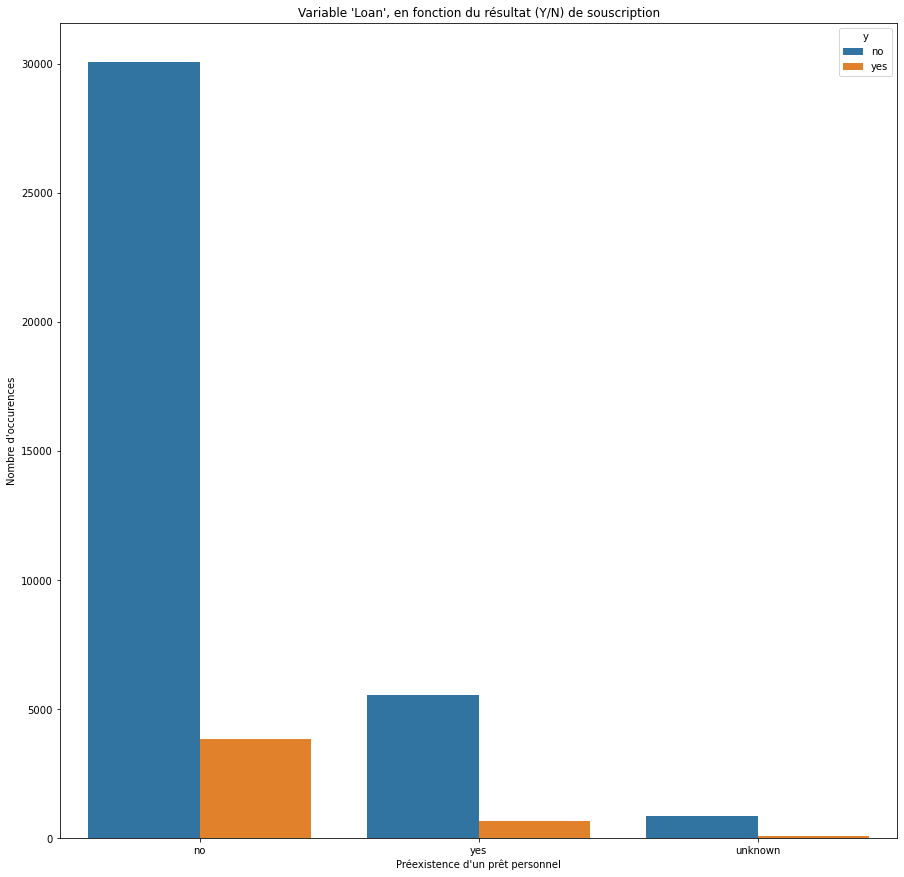

In [33]:
plt.figure(figsize = (15, 15))
sns.countplot(x='loan', data=df, hue = 'y')
plt.xlabel("Préexistence d'un prêt personnel")
plt.ylabel("Nombre d'occurences")
plt.title("Variable 'Loan', en fonction du résultat (Y/N) de souscription");

In [34]:
pd.crosstab(df.y, df.loan, normalize = 0)

loan,no,unknown,yes
y,,,
no,0.823521,0.024167,0.152311
yes,0.829705,0.023065,0.147230


La très grande majorité des personnes contactées n'avaient pas souscrit de prêt personnel, et c'est parmi eux que se retrouvent l'écrasante majorité de ceux qui ont souscrits (83%). Cependant la répartition homogène no/yes entre les trois modalités indique que cette variable est sans impact sur le résultat.  

##### Visualisation de la variable 'Contact', en fonction du résultat (Y/N) de souscription

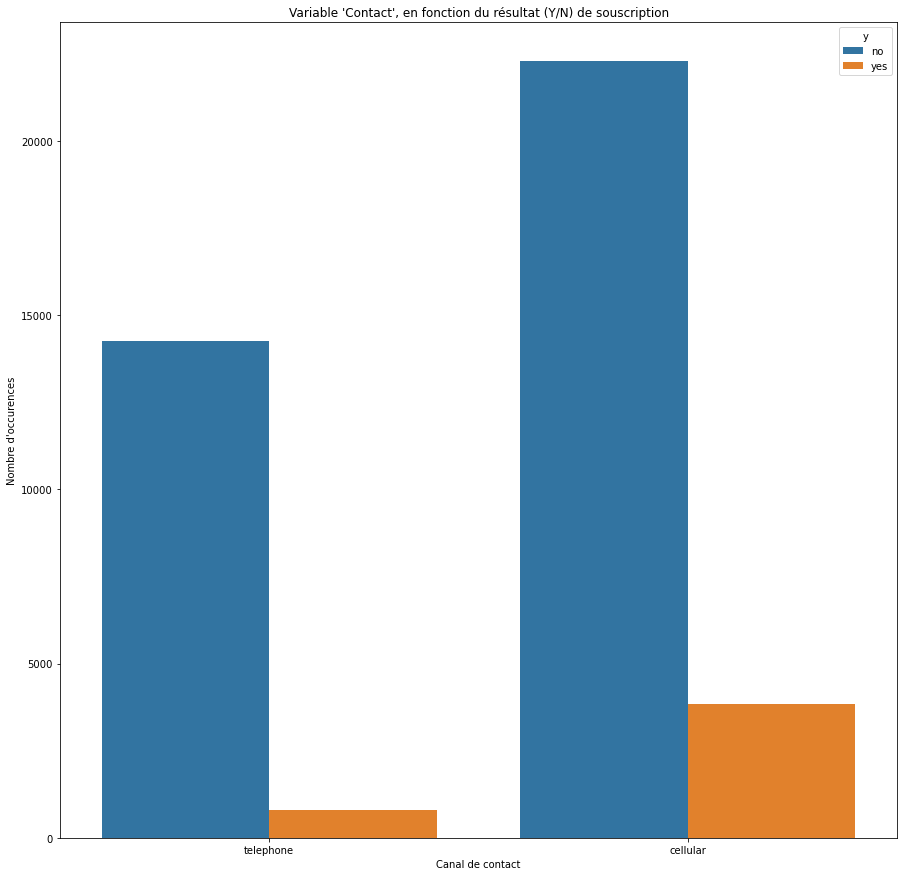

In [35]:
plt.figure(figsize = (15, 15))
sns.countplot(x='contact', data=df, hue = 'y')
plt.xlabel("Canal de contact")
plt.ylabel("Nombre d'occurences")
plt.title("Variable 'Contact', en fonction du résultat (Y/N) de souscription");

In [36]:
pd.crosstab(df.y, df.contact, normalize = 0)

contact,cellular,telephone
y,,
no,0.609875,0.390125
yes,0.830351,0.169649


Une majorité des personnes contactées l'ont été via téléphone mobile, et c'est parmi eux que se retrouvent l'écrasante majorité de ceux qui ont souscrits (83%).  

##### Visualisation des variables 'Month' et 'Day of Week', en fonction du résultat (Y/N) de souscription

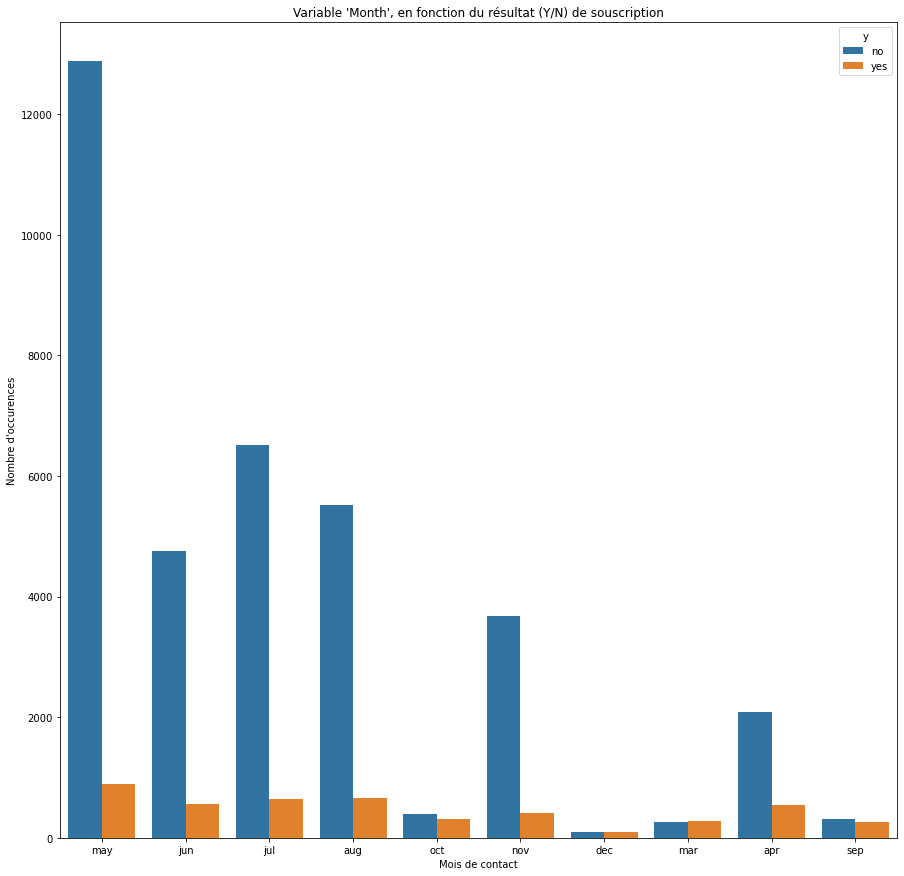

In [37]:
plt.figure(figsize = (15, 15))
sns.countplot(x='month', data=df, hue = 'y')
plt.xlabel("Mois de contact")
plt.ylabel("Nombre d'occurences")
plt.title("Variable 'Month', en fonction du résultat (Y/N) de souscription");

Nous constatons une répartition inégale des Mois, suite à un recouvrement, la campagne durant plus de un an. L'absence d'une variable date (avec l'année) rend difficile une analyse plus précise du phénomène.

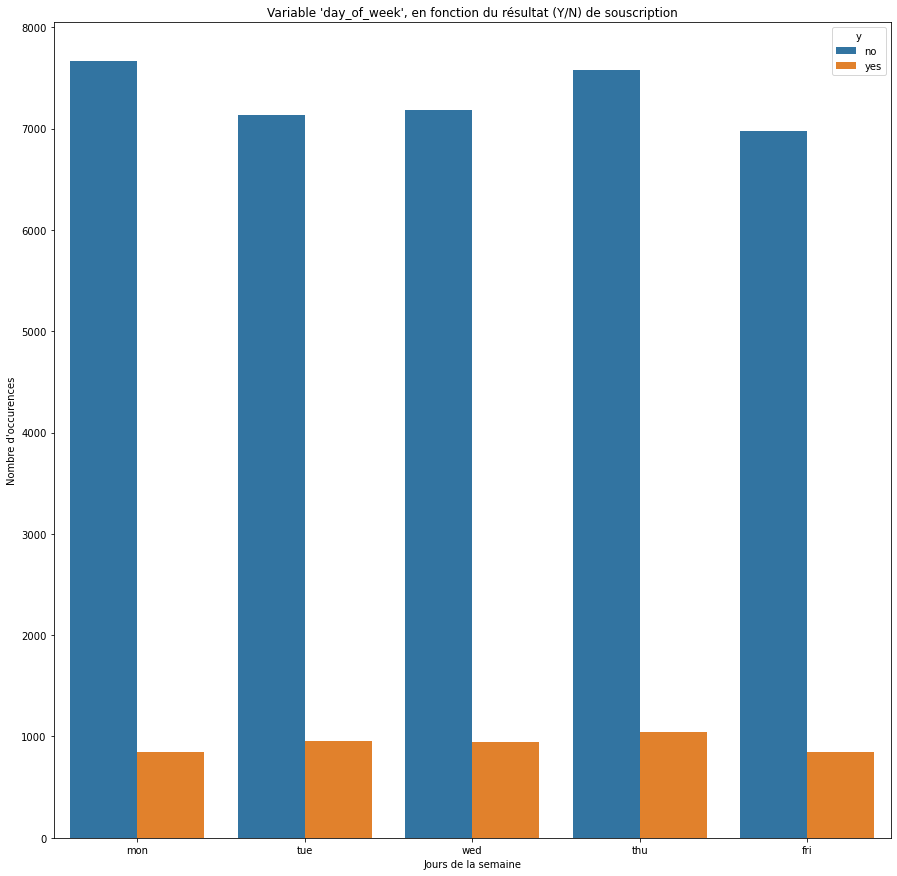

In [38]:
plt.figure(figsize = (15, 15))
sns.countplot(x='day_of_week', data=df, hue = 'y')
plt.xlabel("Jours de la semaine")
plt.ylabel("Nombre d'occurences")
plt.title("Variable 'day_of_week', en fonction du résultat (Y/N) de souscription");

La répartition par jours de la semaine est assez homogène, cela se retrouve dans les proportions de souscriptions. Remarque, nous pouvons constater qu'il n'y a pas de démarchage le week-end.

##### Visualisation de la variable 'Poutcome', en fonction du résultat (Y/N) de souscription

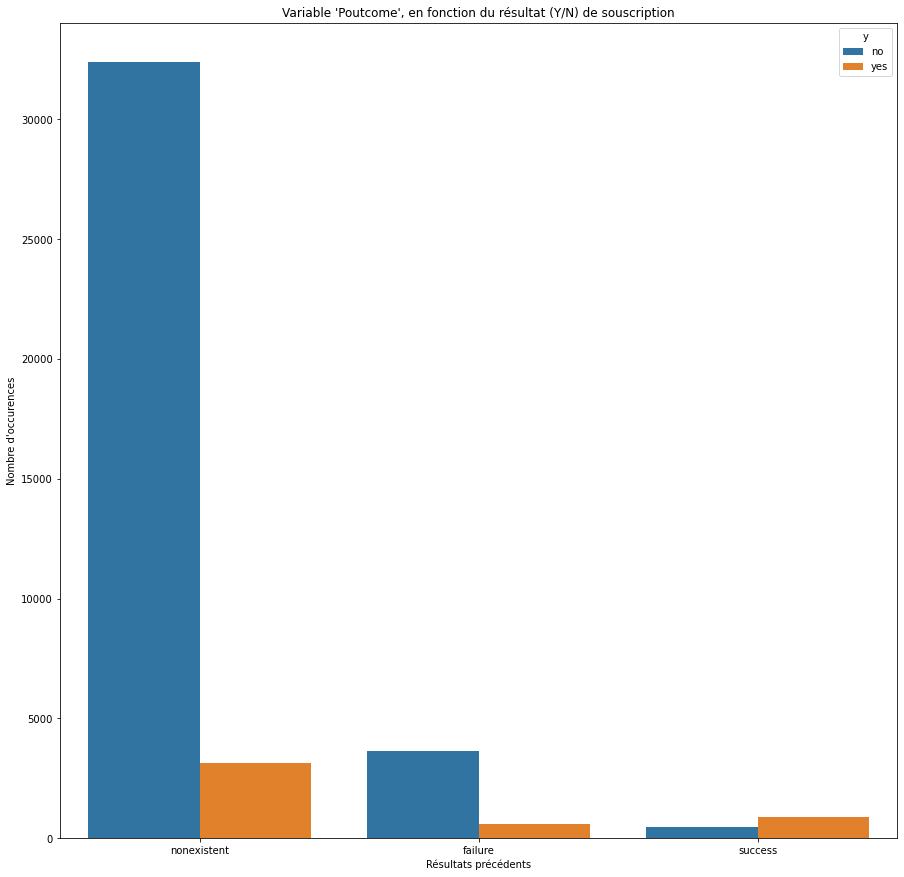

In [39]:
plt.figure(figsize = (15, 15))
sns.countplot(x='poutcome', data=df, hue = 'y')
plt.xlabel("Résultats précédents")
plt.ylabel("Nombre d'occurences")
plt.title("Variable 'Poutcome', en fonction du résultat (Y/N) de souscription");

In [40]:
pd.crosstab(df.y, df.poutcome, normalize = 0)

poutcome,failure,nonexistent,success
y,,,
no,0.099817,0.887073,0.013110
yes,0.130416,0.676870,0.192714


La trés grande majorité des personnes contactées l'ont été pour la première fois (nonexistent), et c'est parmi eux que nous retrouvons la plus forte proportion de ceux qui ont souscrits (67%).

In [41]:
pd.crosstab(df.y, df.poutcome, normalize = 1)


poutcome,failure,nonexistent,success
y,,,
no,0.857714,0.911676,0.348871
yes,0.142286,0.088324,0.651129




Nous remarquons par ailleurs que 35% des personnes qui avaient déjà souscrit un dépôt à terme, n'ont pas souhaitées en souscrire un nouveau, à l'occasion de cette campagne.

##### Visualisation de la variable cible 'Y' résultat de la souscription

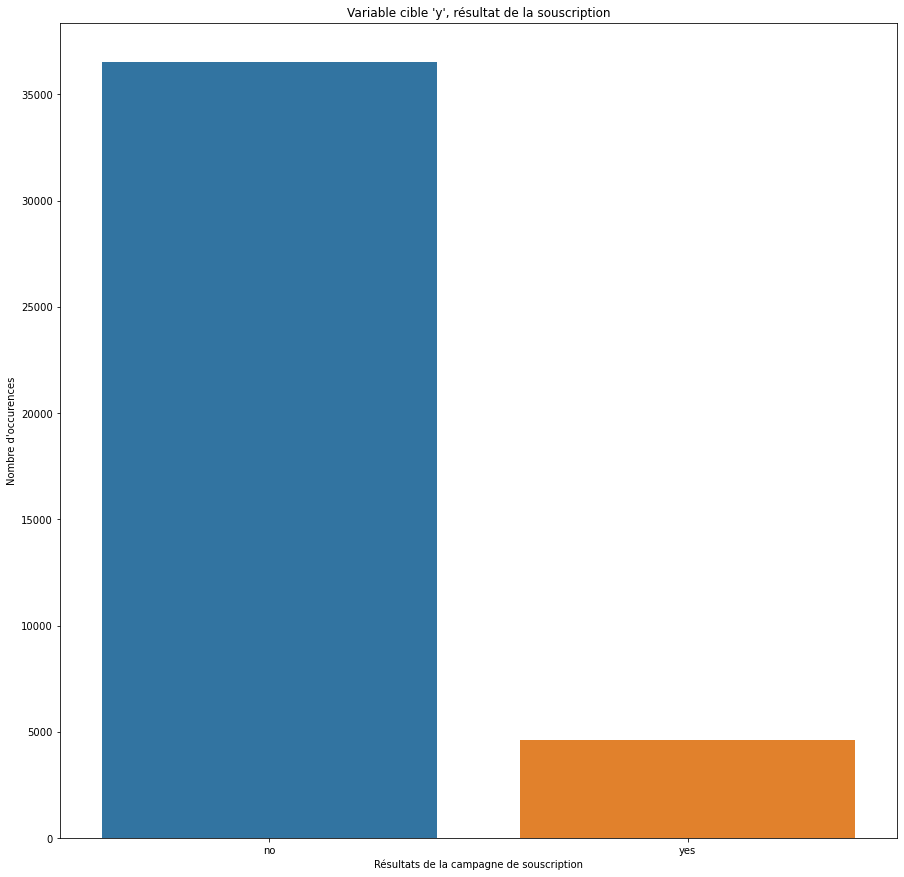

In [42]:
plt.figure(figsize = (15, 15))
sns.countplot(x='y', data=df)
plt.xlabel("Résultats de la campagne de souscription")
plt.ylabel("Nombre d'occurences")
plt.title("Variable cible 'y', résultat de la souscription");

In [43]:
df['y'].value_counts(normalize = True)

no     0.887337
yes    0.112663
Name: y, dtype: float64

Le résultat de la campagne de télémarketing bancaire est plutôt bon avec 11% de souscription de dépôt à terme.
Remarque, pour les étapes de modélisations à suivre nous devrons certainement retravailler la taille de l'échantillon (undersampling ?) pour ré-équilibrer les 2 modalités.

#### Tests Statistiques

Nous étudierons ici les varaibles qualitatives, pour les variables quantitative on se reportera utilement à la matrice de corrélation préalablement étudiée ('heatmap')

##### Tests du Chi2 et de V de Cramer pour les variables qualitatives

In [44]:
def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

df_quali = df[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week','poutcome']]
colonne = (df_quali.columns)

for index, element in enumerate (colonne):
        table = pd.crosstab(df_quali[element],df['y'])
        display(element,V_Cramer(table, df_quali.shape[0]))

'job'

0.15195496226188143

'marital'

0.05397591965805853

'education'

0.0671834857776241

'default'

0.09912256778551454

'housing'

0.009533253430909073

'loan'

0.0

'contact'

0.14461226452325537

'month'

0.2741230962483959

'day_of_week'

0.023143461958776656

'poutcome'

0.32044835703020846

Les V Cramer ne sont pas très élevés, nous pouvons en déduire que la corrélation est faible sans pour autant être négligeable surtout pour la variable 'poutcome' (0,32) et la variable 'month' (0,27). Enfin, nous pouvons confirmer que la variable 'loan' n'est pas corrélée au résultat (cf. analyse visuelle). 

##### Test ANOVA entre la variable qualitative 'Education' et la variable quantitative 'Duration'

Notre hypothèse (H0) est que le niveau d'études n'influe pas sur la durée de l'entretien. C'est à dire que les variable 'Education' et 'Duration' sont indépendantes.

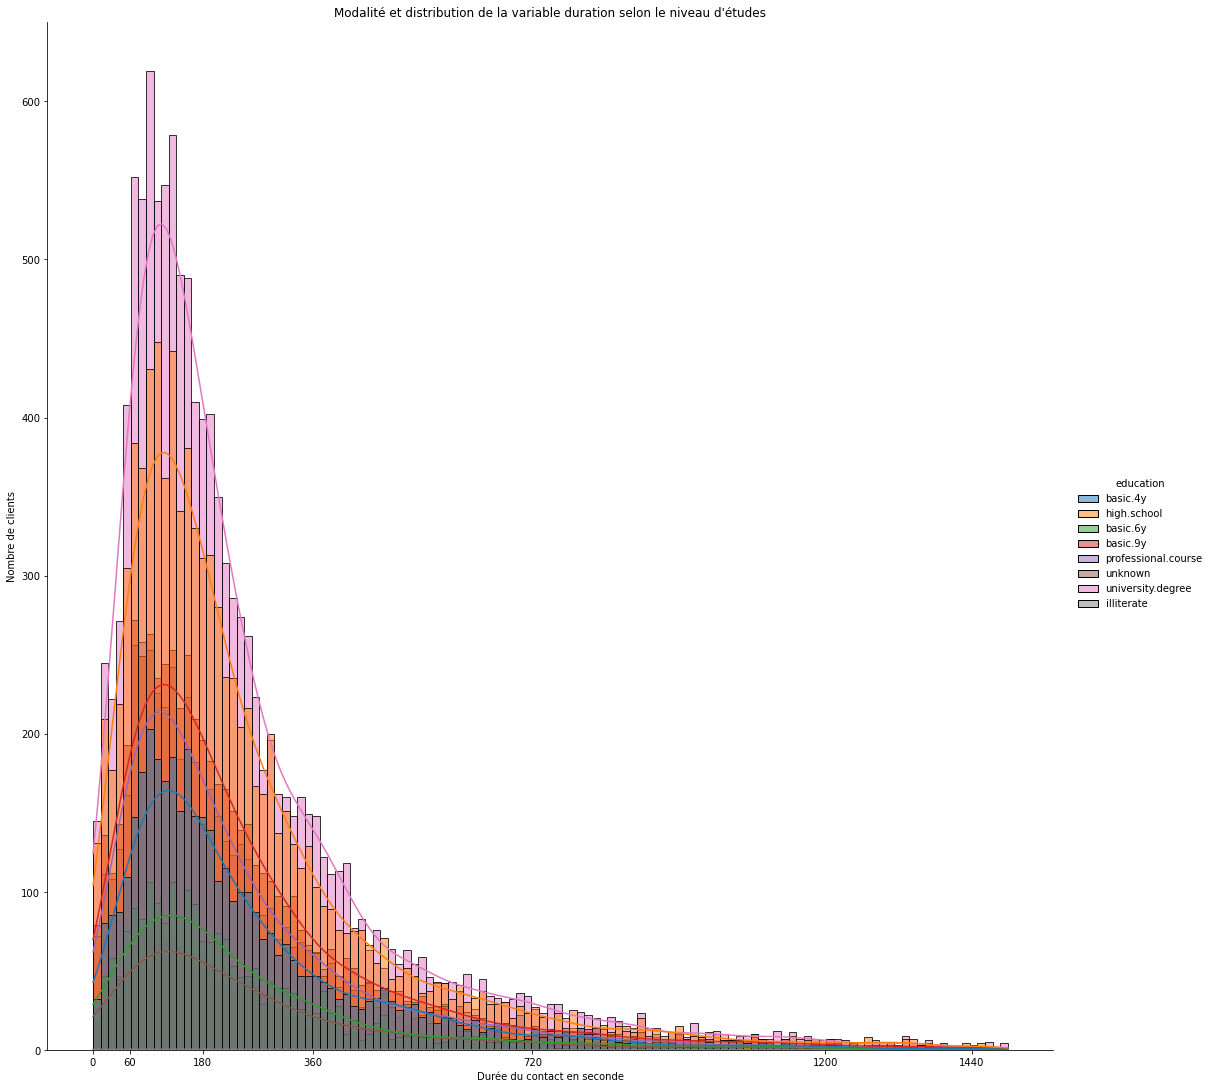

In [45]:

sns.displot(data=df[df['duration'] < 1500], x="duration", kde= True,hue = 'education', height=15 )
plt.xticks([0,60,180,360,720,1200,1440])
plt.xlabel("Durée du contact en seconde")
plt.ylabel("Nombre de clients")
plt.title("Modalité et distribution de la variable duration selon le niveau d'études"); 

In [46]:
result = statsmodels.formula.api.ols('duration ~ education', data=df).fit()
table = statsmodels.api.stats.anova_lm(result)
display(table)

,df,sum_sq,mean_sq,F,PR(>F)
education,7.0,9.067359e+05,129533.696421,1.926763,0.061117
Residual,41168.0,2.767669e+09,67228.657240,NaN,NaN


Le graphique nous montre que la distribution de la durée du contact semble corrélée au niveau d'éducation du client.

En faisant le test ANOVA, la p-value (6%) est supérieure de peu à la référence généralement admise (5%). Ce qui ne nous permettrait pas de rejeter l'hypothèse d'indépendance.

Cependant dans le cas de marketing de masse, comme c'est le cas ici, il est d'usage d'augmenter ce seuil jusqu'à une valeur de 10%. En considérant ce nouveau seuil, nous pouvons donc rejeter l'hypothèse d'indépendance de ces deux variables.
Nous affirmerons donc que le niveau d'études du prospect à un effet statistique significatif sur la durée de l'entretien.

Il semble que plus le niveau d'éducation est élevé plus la durée du contact est élevé. Ceci peut s'expliquer par une capacité accrue à demander des détails techniques sur les conditions du dépôt à terme.


## 4) Préprocessing

---


### A. Travail sur les variables Qualitatives
Nous allons ici transformer les variables Qualitatives en variables Quantitatives. Pour les variables Qualitatives sans notion de progression, nous utiliserons la 'dummification'.

In [47]:
df = df.join(pd.get_dummies(df.job, prefix='JT'))

In [48]:
df = df.join(pd.get_dummies(df.marital, prefix='MS'))

In [49]:
df = df.join(pd.get_dummies(df.education, prefix='EL'))

In [50]:
df = df.join(pd.get_dummies(df.contact, prefix='CO'))

In [51]:
df = df.join(pd.get_dummies(df.poutcome, prefix='PO'))

In [52]:
df = df.join(pd.get_dummies(df.default, prefix='DF'))

In [53]:
df = df.join(pd.get_dummies(df.housing, prefix='HO'))

In [54]:
df = df.join(pd.get_dummies(df.loan, prefix='LO'))

In [55]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,PO_success,DF_no,DF_unknown,DF_yes,HO_no,HO_unknown,HO_yes,LO_no,LO_unknown,LO_yes
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,1,0,0,1,0,0,1,0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,0,1,0,1,0,0,1,0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,1,0,0,0,0,1,1,0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,1,0,0,1,0,0,1,0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,1,0,0,1,0,0,0,0,1


Pour les variables Qualitatives avec notion d'ordre, nous les transformerons en suite croissante de 1 à n.

In [56]:
df['Month_num'] = df['month']
df['Month_num'].replace({'jan': 1}, inplace=True)
df['Month_num'].replace({'feb': 2}, inplace=True)
df['Month_num'].replace({'mar': 3}, inplace=True)
df['Month_num'].replace({'apr': 4}, inplace=True)
df['Month_num'].replace({'may': 5}, inplace=True)
df['Month_num'].replace({'jun': 6}, inplace=True)
df['Month_num'].replace({'jul': 7}, inplace=True)
df['Month_num'].replace({'aug': 8}, inplace=True)
df['Month_num'].replace({'sep': 9}, inplace=True)
df['Month_num'].replace({'oct': 10}, inplace=True)
df['Month_num'].replace({'nov': 11}, inplace=True)
df['Month_num'].replace({'dec': 12}, inplace=True)
df['Month_num'].value_counts()

5     13767
7      7169
8      6176
6      5318
11     4100
4      2631
10      717
9       570
3       546
12      182
Name: Month_num, dtype: int64

In [57]:
df['Day_of_Week_num'] = df['day_of_week']
df['Day_of_Week_num'].replace({'mon': 1}, inplace=True)
df['Day_of_Week_num'].replace({'tue': 2}, inplace=True)
df['Day_of_Week_num'].replace({'wed': 3}, inplace=True)
df['Day_of_Week_num'].replace({'thu': 4}, inplace=True)
df['Day_of_Week_num'].replace({'fri': 5}, inplace=True)
df['Day_of_Week_num'].value_counts()

4    8618
1    8512
3    8134
2    8086
5    7826
Name: Day_of_Week_num, dtype: int64

Pour vérification, je relance la matrice de corrélation.

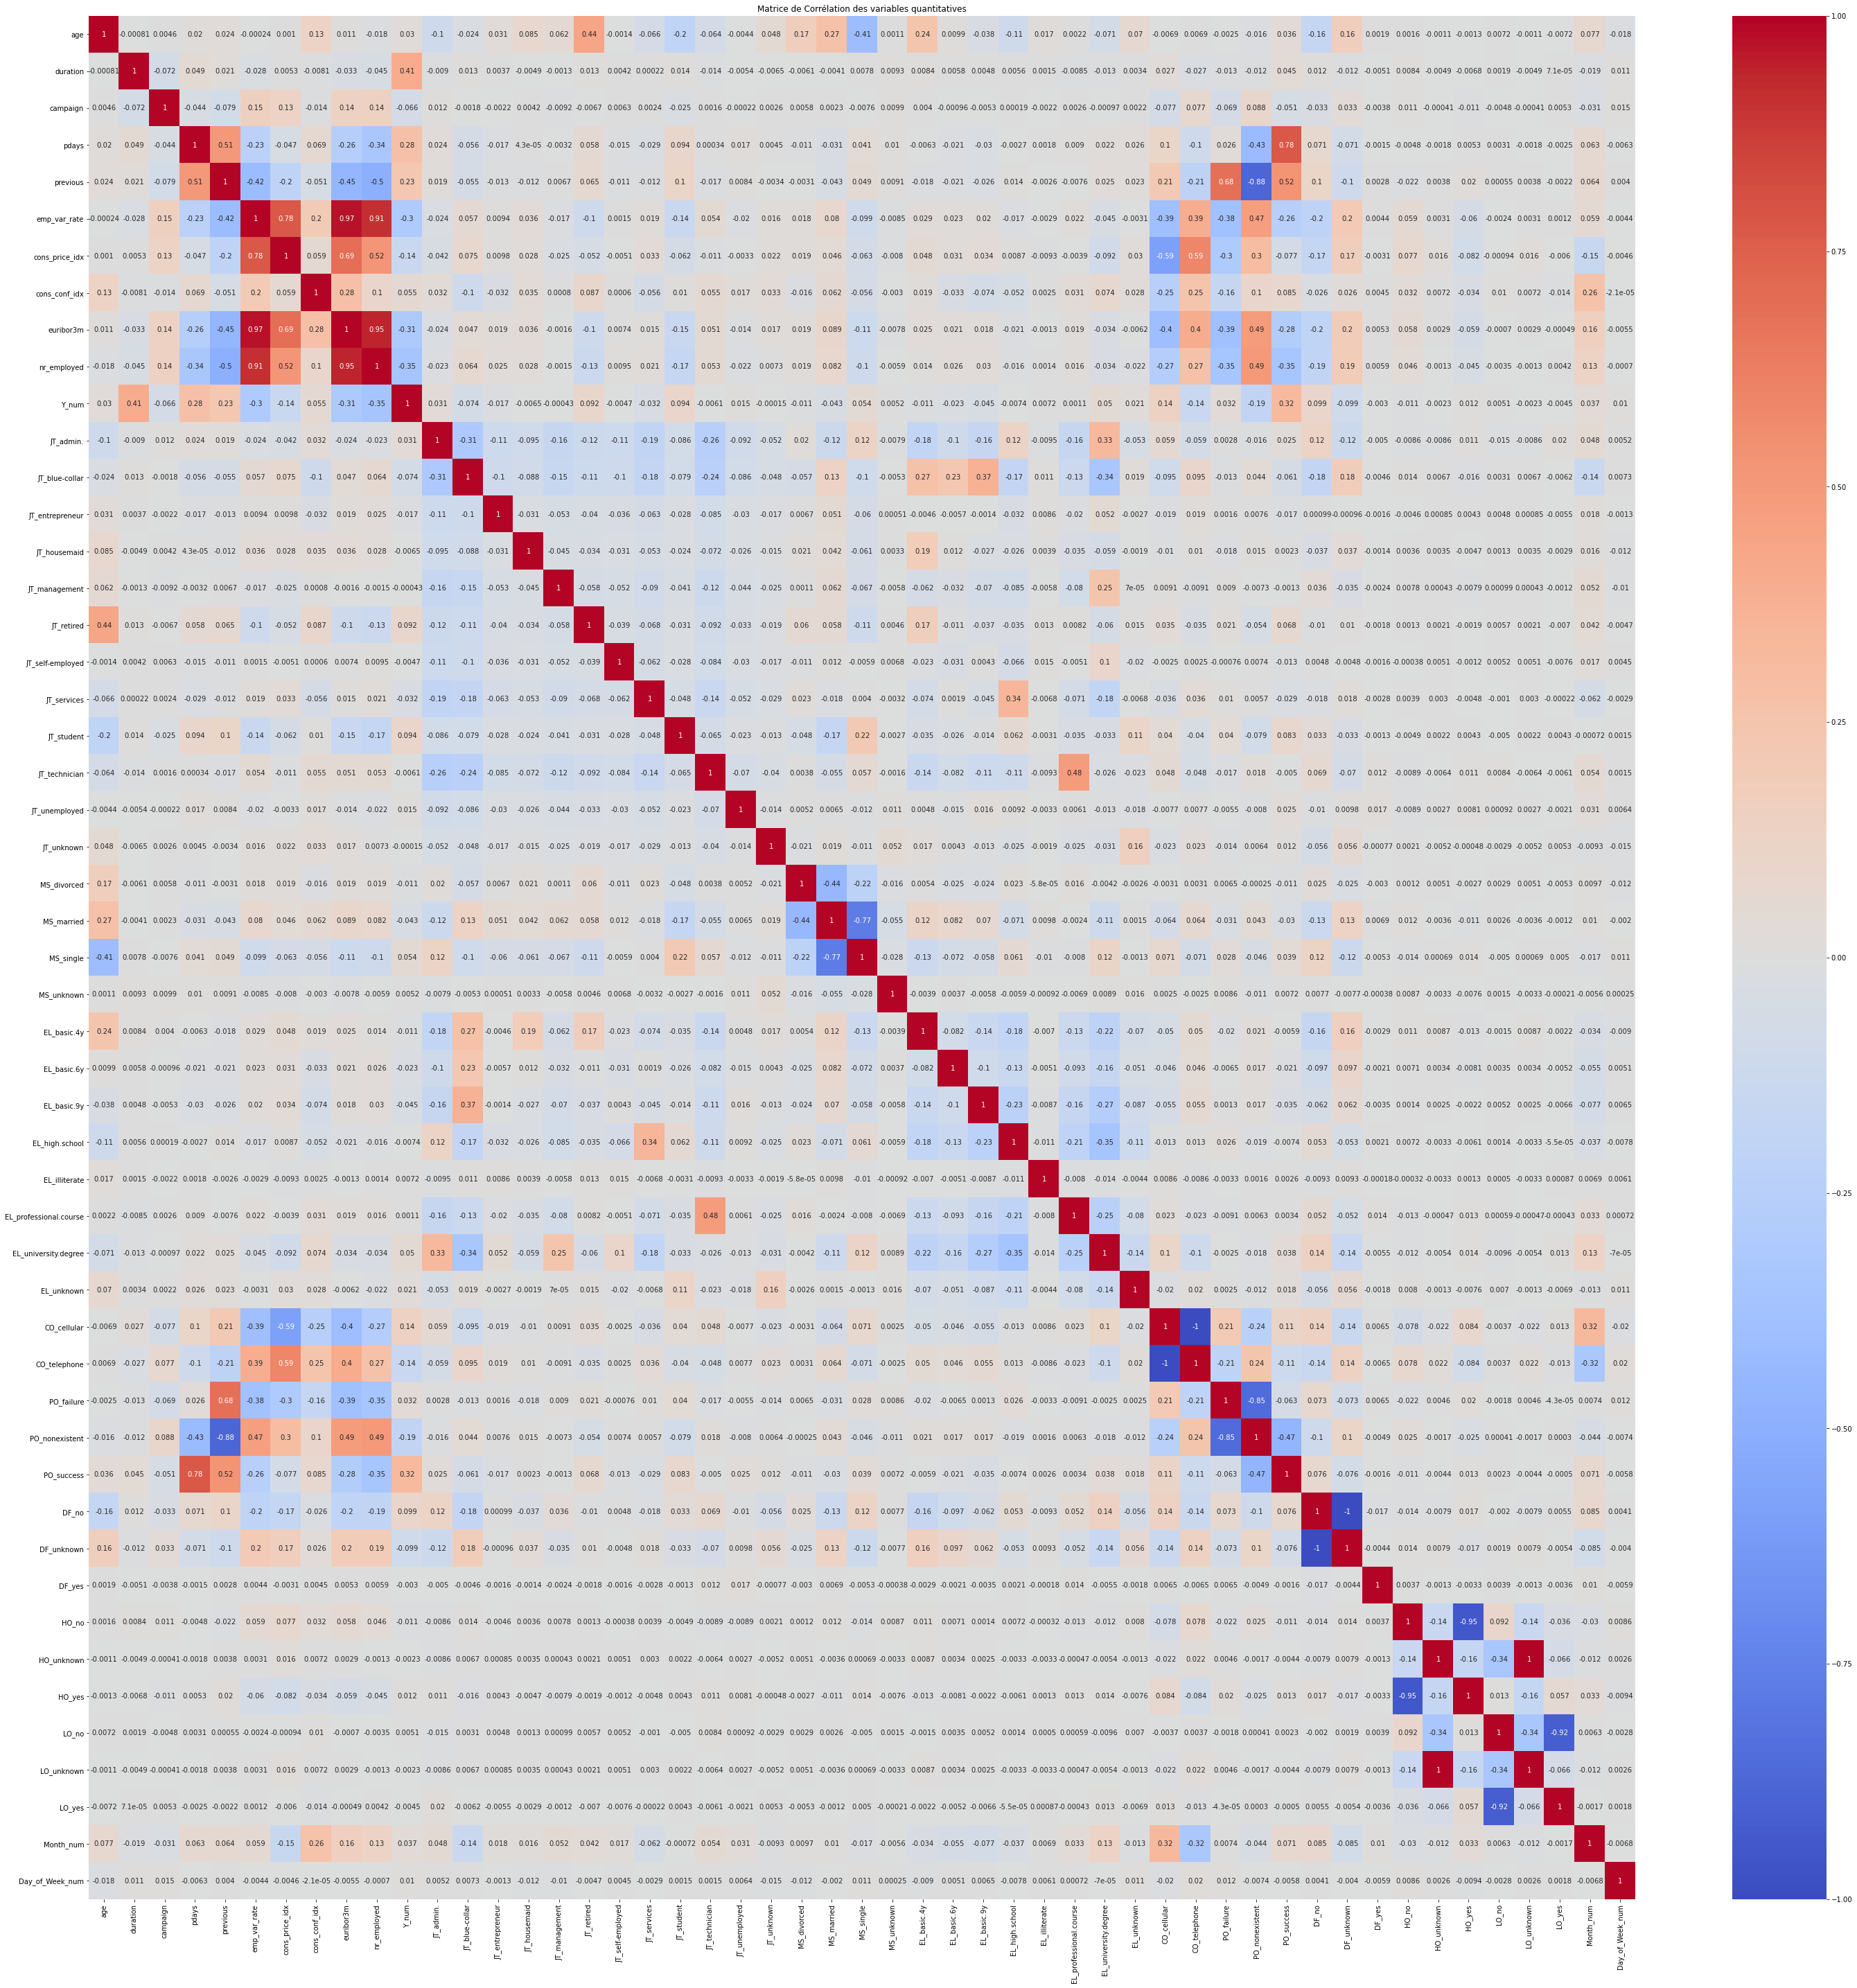

In [58]:
cor = df.corr()

fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(cor, annot=True, ax=ax, cmap='coolwarm')
plt.title('Matrice de Corrélation des variables quantitatives');

### B. Split et Scaling
Deux Datasets seront constitués 'Target' et 'Data'.
Ces Dataset seront ensuite répartis entre base d'apprentissage et base test. On retient une répartation 80/20 dans un premier temps.
Ces variables seront ensuite centrées réduites.

In [59]:
Target = df['Y_num']

Data = df.drop (['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y', 'Y_num',
                ], axis = 1)

Data.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,DF_unknown,DF_yes,HO_no,HO_unknown,HO_yes,LO_no,LO_unknown,LO_yes,Month_num,Day_of_Week_num
0,56,261,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,1,0,0,1,0,0,5,1
1,57,149,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,1,0,0,1,0,0,5,1
2,37,226,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,1,1,0,0,5,1
3,40,151,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,1,0,0,1,0,0,5,1
4,56,307,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,1,0,0,0,0,1,5,1


In [60]:
X_train, X_test, y_train, y_test=train_test_split(Data, Target, test_size=0.2, random_state=974)

In [61]:
scaler=preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)

scaler=preprocessing.StandardScaler().fit(X_test)
X_test_scaled=scaler.transform(X_test)
 

### C. Equilibrage du jeu de données
Comme vu précédemment notre base de données est déséquilibrée. Nous utiliserons la technique d'oversampling SMOTE pour rééquilibrer les données. Cette technique fonctionne en augmentant le nombre d'observations de la classe minoritaire afin d'arriver à un ratio classe minoritaire/classe majoritaire satisfaisant.

In [62]:
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train_scaled, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_ro).value_counts()))

Classes échantillon oversampled : {1: 29218, 0: 29218}


In [63]:
## undersampling aléatoire (RandomUnderSampler)
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train_scaled, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_ru).value_counts()))

Classes échantillon undersampled : {1: 3722, 0: 3722}


## 5) Modélisations

---


### A. Régression Logistique

In [64]:
# Création du classifieur et construction du modèle sur les données d'entraînement
clf = linear_model.LogisticRegression(C=1.0)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

print(classification_report(y_test, y_pred))
print(clf.score(X_test_scaled, y_test))

Classe prédite     0    1
Classe réelle            
0               7120  199
1                543  374
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7319
           1       0.65      0.41      0.50       917

    accuracy                           0.91      8236
   macro avg       0.79      0.69      0.73      8236
weighted avg       0.90      0.91      0.90      8236

0.9099077221952404


Avec oversampling

In [65]:
# Création du classifieur et construction du modèle sur les données d'entraînement
clf = linear_model.LogisticRegression(C=1.0)
clf.fit(X_ro, y_ro)

y_pred = clf.predict(X_test_scaled)

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

print(classification_report_imbalanced(y_test, y_pred))
#print(classification_report(y_test, y_pred))
print(clf.score(X_test_scaled, y_test))

Classe prédite     0     1
Classe réelle             
0               6260  1059
1                117   800
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.86      0.87      0.91      0.86      0.74      7319
          1       0.43      0.87      0.86      0.58      0.86      0.75       917

avg / total       0.92      0.86      0.87      0.88      0.86      0.75      8236

0.8572122389509471


Avec undersampling

In [66]:
# Création du classifieur et construction du modèle sur les données d'entraînement
clf = linear_model.LogisticRegression(C=1.0)
clf.fit(X_ru, y_ru)

y_pred = clf.predict(X_test_scaled)

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

print(classification_report_imbalanced(y_test, y_pred))
#print(classification_report(y_test, y_pred))
print(clf.score(X_test_scaled, y_test))

Classe prédite     0     1
Classe réelle             
0               6256  1063
1                117   800
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.85      0.87      0.91      0.86      0.74      7319
          1       0.43      0.87      0.85      0.58      0.86      0.75       917

avg / total       0.92      0.86      0.87      0.88      0.86      0.74      8236

0.8567265662943176


### B. KNN

In [67]:
### modéle : K-plus proches voisins avec n_neighbors : 2 à 40

# Sélection des hyperparamètres sur l'échantillon d’apprentissage par validation croisée
knn = neighbors.KNeighborsClassifier()
parametres = {'n_neighbors': range(2,41)}
grid_knn = GridSearchCV(estimator=knn, param_grid=parametres)
#swapper les 2 lignes suivantes en cas d'oversampling
#grid = grid_knn.fit(X_ro, y_ro)
grid = grid_knn.fit(X_train_scaled, y_train)
print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']])
# les hyperparamètres retenus
print(grid_knn.best_params_)
# modèle appliqué à l'ensemble de test, et matrice de confusion
y_pred = grid_knn.predict(X_test_scaled)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
# score du modèle sur ce dernier
#print(classification_report_imbalanced(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(grid.score(X_test_scaled, y_test))

                 params  mean_test_score
0    {'n_neighbors': 2}         0.893230
1    {'n_neighbors': 3}         0.892077
2    {'n_neighbors': 4}         0.894869
3    {'n_neighbors': 5}         0.894961
4    {'n_neighbors': 6}         0.896539
5    {'n_neighbors': 7}         0.896661
6    {'n_neighbors': 8}         0.897298
7    {'n_neighbors': 9}         0.897693
8   {'n_neighbors': 10}         0.896903
9   {'n_neighbors': 11}         0.898330
10  {'n_neighbors': 12}         0.898087
11  {'n_neighbors': 13}         0.898877
12  {'n_neighbors': 14}         0.898846
13  {'n_neighbors': 15}         0.899302
14  {'n_neighbors': 16}         0.899241
15  {'n_neighbors': 17}         0.899362
16  {'n_neighbors': 18}         0.898664
17  {'n_neighbors': 19}         0.898998
18  {'n_neighbors': 20}         0.898270
19  {'n_neighbors': 21}         0.898816
20  {'n_neighbors': 22}         0.898543
21  {'n_neighbors': 23}         0.899029
22  {'n_neighbors': 24}         0.898695
23  {'n_neighbor

Avec oversampling

In [68]:
### modéle : K-plus proches voisins avec n_neighbors : 2 à 40

# Sélection des hyperparamètres sur l'échantillon d’apprentissage par validation croisée
knn = neighbors.KNeighborsClassifier()
parametres = {'n_neighbors': range(2,41)}
grid_knn = GridSearchCV(estimator=knn, param_grid=parametres)
#swapper les 2 lignes suivantes en cas d'oversampling
grid = grid_knn.fit(X_ro, y_ro)
#grid = grid_knn.fit(X_train_scaled, y_train)
print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']])
# les hyperparamètres retenus
print(grid_knn.best_params_)
# modèle appliqué à l'ensemble de test, et matrice de confusion
y_pred = grid_knn.predict(X_test_scaled)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
# score du modèle sur ce dernier
print(classification_report_imbalanced(y_test, y_pred))
#print(classification_report(y_test, y_pred))
print(grid.score(X_test_scaled, y_test))

                 params  mean_test_score
0    {'n_neighbors': 2}         0.963618
1    {'n_neighbors': 3}         0.940875
2    {'n_neighbors': 4}         0.936033
3    {'n_neighbors': 5}         0.919467
4    {'n_neighbors': 6}         0.911134
5    {'n_neighbors': 7}         0.900335
6    {'n_neighbors': 8}         0.890941
7    {'n_neighbors': 9}         0.882333
8   {'n_neighbors': 10}         0.874102
9   {'n_neighbors': 11}         0.868848
10  {'n_neighbors': 12}         0.863047
11  {'n_neighbors': 13}         0.860497
12  {'n_neighbors': 14}         0.857126
13  {'n_neighbors': 15}         0.855295
14  {'n_neighbors': 16}         0.854148
15  {'n_neighbors': 17}         0.853960
16  {'n_neighbors': 18}         0.852916
17  {'n_neighbors': 19}         0.853156
18  {'n_neighbors': 20}         0.850880
19  {'n_neighbors': 21}         0.849733
20  {'n_neighbors': 22}         0.846071
21  {'n_neighbors': 23}         0.845797
22  {'n_neighbors': 24}         0.843470
23  {'n_neighbor

Avec undersampling

In [69]:
### modéle : K-plus proches voisins avec n_neighbors : 2 à 40

# Sélection des hyperparamètres sur l'échantillon d’apprentissage par validation croisée
knn = neighbors.KNeighborsClassifier()
parametres = {'n_neighbors': range(2,41)}
grid_knn = GridSearchCV(estimator=knn, param_grid=parametres)
#swapper les 2 lignes suivantes en cas d'undersampling
grid = grid_knn.fit(X_ru, y_ru)
#grid = grid_knn.fit(X_train_scaled, y_train)
print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']])
# les hyperparamètres retenus
print(grid_knn.best_params_)
# modèle appliqué à l'ensemble de test, et matrice de confusion
y_pred = grid_knn.predict(X_test_scaled)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
# score du modèle sur ce dernier
print(classification_report_imbalanced(y_test, y_pred))
#print(classification_report(y_test, y_pred))
print(grid.score(X_test_scaled, y_test))

                 params  mean_test_score
0    {'n_neighbors': 2}         0.723134
1    {'n_neighbors': 3}         0.775660
2    {'n_neighbors': 4}         0.758061
3    {'n_neighbors': 5}         0.782646
4    {'n_neighbors': 6}         0.771899
5    {'n_neighbors': 7}         0.786541
6    {'n_neighbors': 8}         0.774719
7    {'n_neighbors': 9}         0.790974
8   {'n_neighbors': 10}         0.778614
9   {'n_neighbors': 11}         0.792452
10  {'n_neighbors': 12}         0.784660
11  {'n_neighbors': 13}         0.792316
12  {'n_neighbors': 14}         0.783316
13  {'n_neighbors': 15}         0.791779
14  {'n_neighbors': 16}         0.785734
15  {'n_neighbors': 17}         0.791779
16  {'n_neighbors': 18}         0.784122
17  {'n_neighbors': 19}         0.790839
18  {'n_neighbors': 20}         0.784391
19  {'n_neighbors': 21}         0.790838
20  {'n_neighbors': 22}         0.785465
21  {'n_neighbors': 23}         0.792048
22  {'n_neighbors': 24}         0.786540
23  {'n_neighbor

### C. SVM

In [70]:
### modele : SVM avec kernel : 'linear', 'sigmoid', 'rbf' et C : 0.1, 1, 10, 20
# Sélection des hyperparamètres sur l'échantillon d’apprentissage par validation croisée
clf = svm.SVC()
parametres = {'C':[0.1,1,10,20], 'kernel':['linear', 'sigmoid', 'rbf']}

grid_clf = GridSearchCV(estimator=clf, param_grid=parametres)

#swapper les 2 lignes suivantes en cas d'oversampling
#grid = grid_clf.fit(X_ro, y_ro)
grid = grid_clf.fit(X_train_scaled, y_train)

print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']])

# les hyperparamètres retenus
print(grid_clf.best_params_)

# modèle appliqué à l'ensemble de test, et  la matrice de confusion
y_pred = grid_clf.predict(X_test_scaled)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# score du modèle sur ce dernier
#print(classification_report_imbalanced(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(grid.score(X_test_scaled, y_test))

                             params  mean_test_score
0    {'C': 0.1, 'kernel': 'linear'}         0.901700
1   {'C': 0.1, 'kernel': 'sigmoid'}         0.897268
2       {'C': 0.1, 'kernel': 'rbf'}         0.898573
3      {'C': 1, 'kernel': 'linear'}         0.901821
4     {'C': 1, 'kernel': 'sigmoid'}         0.876655
5         {'C': 1, 'kernel': 'rbf'}         0.906254
6     {'C': 10, 'kernel': 'linear'}         0.901852
7    {'C': 10, 'kernel': 'sigmoid'}         0.874408
8        {'C': 10, 'kernel': 'rbf'}         0.904614
9     {'C': 20, 'kernel': 'linear'}         0.901852
10   {'C': 20, 'kernel': 'sigmoid'}         0.871160
11       {'C': 20, 'kernel': 'rbf'}         0.901700
{'C': 1, 'kernel': 'rbf'}
Classe prédite     0    1
Classe réelle            
0               7148  171
1                599  318
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7319
           1       0.65      0.35      0.45       917

    accuracy     

Avec oversampling

In [71]:
### modele : SVM avec kernel : 'linear', 'sigmoid', 'rbf' et C : 0.1, 1, 10, 20
# Sélection des hyperparamètres sur l'échantillon d’apprentissage par validation croisée
clf = svm.SVC()
parametres = {'C':[0.1,1,10,20], 'kernel':['linear', 'sigmoid', 'rbf']}

grid_clf = GridSearchCV(estimator=clf, param_grid=parametres)

#swapper les 2 lignes suivantes en cas d'oversampling
grid = grid_clf.fit(X_ro, y_ro)
#grid = grid_clf.fit(X_train_scaled, y_train)

print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']])

# les hyperparamètres retenus
print(grid_clf.best_params_)

# modèle appliqué à l'ensemble de test, et  la matrice de confusion
y_pred = grid_clf.predict(X_test_scaled)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# score du modèle sur ce dernier
print(classification_report_imbalanced(y_test, y_pred))
#print(classification_report(y_test, y_pred))

print(grid.score(X_test_scaled, y_test))

                             params  mean_test_score
0    {'C': 0.1, 'kernel': 'linear'}         0.865905
1   {'C': 0.1, 'kernel': 'sigmoid'}         0.807704
2       {'C': 0.1, 'kernel': 'rbf'}         0.874256
3      {'C': 1, 'kernel': 'linear'}         0.865511
4     {'C': 1, 'kernel': 'sigmoid'}         0.778835
5         {'C': 1, 'kernel': 'rbf'}         0.901379
6     {'C': 10, 'kernel': 'linear'}         0.865511
7    {'C': 10, 'kernel': 'sigmoid'}         0.779759
8        {'C': 10, 'kernel': 'rbf'}         0.927545
9     {'C': 20, 'kernel': 'linear'}         0.865597
10   {'C': 20, 'kernel': 'sigmoid'}         0.780426
11       {'C': 20, 'kernel': 'rbf'}         0.933072
{'C': 20, 'kernel': 'rbf'}
Classe prédite     0    1
Classe réelle            
0               6537  782
1                267  650
                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.89      0.71      0.93      0.80      0.64      7319
          1  

Avec undersampling

In [72]:
### modele : SVM avec kernel : 'linear', 'sigmoid', 'rbf' et C : 0.1, 1, 10, 20
# Sélection des hyperparamètres sur l'échantillon d’apprentissage par validation croisée
clf = svm.SVC()
parametres = {'C':[0.1,1,10,20], 'kernel':['linear', 'sigmoid', 'rbf']}

grid_clf = GridSearchCV(estimator=clf, param_grid=parametres)

#swapper les 2 lignes suivantes en cas d'undersampling
grid = grid_clf.fit(X_ru, y_ru)
#grid = grid_clf.fit(X_train_scaled, y_train)

print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']])

# les hyperparamètres retenus
print(grid_clf.best_params_)

# modèle appliqué à l'ensemble de test, et  la matrice de confusion
y_pred = grid_clf.predict(X_test_scaled)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# score du modèle sur ce dernier
print(classification_report_imbalanced(y_test, y_pred))
#print(classification_report(y_test, y_pred))

print(grid.score(X_test_scaled, y_test))

                             params  mean_test_score
0    {'C': 0.1, 'kernel': 'linear'}         0.866201
1   {'C': 0.1, 'kernel': 'sigmoid'}         0.853439
2       {'C': 0.1, 'kernel': 'rbf'}         0.856798
3      {'C': 1, 'kernel': 'linear'}         0.866336
4     {'C': 1, 'kernel': 'sigmoid'}         0.804677
5         {'C': 1, 'kernel': 'rbf'}         0.862843
6     {'C': 10, 'kernel': 'linear'}         0.866201
7    {'C': 10, 'kernel': 'sigmoid'}         0.781704
8        {'C': 10, 'kernel': 'rbf'}         0.854111
9     {'C': 20, 'kernel': 'linear'}         0.866604
10   {'C': 20, 'kernel': 'sigmoid'}         0.780495
11       {'C': 20, 'kernel': 'rbf'}         0.851424
{'C': 20, 'kernel': 'linear'}
Classe prédite     0     1
Classe réelle             
0               6158  1161
1                 97   820
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.84      0.89      0.91      0.87      0.75      7319
      

### D. XGBoost

Avec undersampling

In [73]:
xgb=XGBClassifier()
#X,y  = X_train_scaled, y_train
X,y  = X_ru, y_ru

#swapper les 2 lignes suivantes en cas d'oversampling

#xgb.fit(X_ro, y_ro)

#xgb.fit(X_train_scaled, y_train)

xgb.fit(X, y)

# modèle appliqué à l'ensemble de test, et  la matrice de confusion

y_pred=xgb.predict(X_test_scaled)

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

print(cm)

#score du modèle sur ce dernier

print(classification_report_imbalanced(y_test, y_pred))

print(classification_report(y_test, y_pred))

[05:06:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Temp\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classe prédite     0     1
Classe réelle             
0               6062  1257
1                 84   833
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.83      0.91      0.90      0.87      0.75      7319
          1       0.40      0.91      0.83      0.55      0.87      0.76       917

avg / total       0.92      0.84      0.90      0.86      0.87      0.75      8236

              precision    recall  f1-score   support

           0       0.99      0.83      0.90      7319
           1       0.40      0.91      0.55       917

    accuracy                           0.84      8236
   macro avg       0.69      0.87      0.73      8236
weighted avg       0.92      0.84      0.86      8236



Avec oversampling

In [74]:
xgb=XGBClassifier()

#X,y  = X_train_scaled, y_train

X,y  = X_ro, y_ro

#swapper les 2 lignes suivantes en cas d'oversampling

#xgb.fit(X_ro, y_ro)

#xgb.fit(X_train_scaled, y_train)

xgb.fit(X, y)

# modèle appliqué à l'ensemble de test, et  la matrice de confusion

y_pred=xgb.predict(X_test_scaled)

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

print(cm)

#score du modèle sur ce dernier

print(classification_report_imbalanced(y_test, y_pred))

print(classification_report(y_test, y_pred))

[05:06:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Temp\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classe prédite     0    1
Classe réelle            
0               6483  836
1                186  731
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.89      0.80      0.93      0.84      0.71      7319
          1       0.47      0.80      0.89      0.59      0.84      0.70       917

avg / total       0.92      0.88      0.81      0.89      0.84      0.71      8236

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      7319
           1       0.47      0.80      0.59       917

    accuracy                           0.88      8236
   macro avg       0.72      0.84      0.76      8236
weighted avg       0.92      0.88      0.89      8236



### E.Random Forest

Avec undersampling

In [75]:
# Création du classificateur et construction du modèle sur les données d'entraînement
clf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)

#X,y  = X_train_scaled, y_train

X,y  = X_ru, y_ru

clf.fit(X, y)

y_pred = clf.predict(X_test_scaled)

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

print(cm)

print(classification_report_imbalanced(y_test, y_pred))

print(classification_report(y_test, y_pred))

Classe prédite     0     1
Classe réelle             
0               6029  1290
1                 58   859
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.82      0.94      0.90      0.88      0.76      7319
          1       0.40      0.94      0.82      0.56      0.88      0.78       917

avg / total       0.92      0.84      0.92      0.86      0.88      0.76      8236

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      7319
           1       0.40      0.94      0.56       917

    accuracy                           0.84      8236
   macro avg       0.70      0.88      0.73      8236
weighted avg       0.92      0.84      0.86      8236



Avec oversampling

In [76]:
# Création du classificateur et construction du modèle sur les données d'entraînement
clf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)

#X,y  = X_train_scaled, y_train

X,y  = X_ro, y_ro

clf.fit(X, y)

y_pred = clf.predict(X_test_scaled)

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

print(cm)

print(classification_report_imbalanced(y_test, y_pred))

print(classification_report(y_test, y_pred))


Classe prédite     0    1
Classe réelle            
0               6937  382
1                400  517
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.95      0.56      0.95      0.73      0.55      7319
          1       0.58      0.56      0.95      0.57      0.73      0.51       917

avg / total       0.90      0.91      0.61      0.90      0.73      0.55      8236

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7319
           1       0.58      0.56      0.57       917

    accuracy                           0.91      8236
   macro avg       0.76      0.76      0.76      8236
weighted avg       0.90      0.91      0.90      8236



### F. AdaBoost

Avec undersampling

In [77]:
#X,y  = X_train_scaled, y_train

X,y  = X_ru, y_ru

dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X, y)

ac = AdaBoostClassifier(base_estimator=dtc, n_estimators=400)
ac.fit(X, y)

y_pred = ac.predict(X_test_scaled)

cm = pd.crosstab(y_test, y_pred)

print(cm)

print(classification_report_imbalanced(y_test, y_pred))

print(classification_report(y_test, y_pred))

col_0     0     1
Y_num            
0      6010  1309
1       101   816
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.82      0.89      0.90      0.85      0.73      7319
          1       0.38      0.89      0.82      0.54      0.85      0.74       917

avg / total       0.92      0.83      0.88      0.86      0.85      0.73      8236

              precision    recall  f1-score   support

           0       0.98      0.82      0.90      7319
           1       0.38      0.89      0.54       917

    accuracy                           0.83      8236
   macro avg       0.68      0.86      0.72      8236
weighted avg       0.92      0.83      0.86      8236



Avec oversampling

In [78]:
#X,y  = X_train_scaled, y_train

X,y  = X_ro, y_ro

dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X, y)

ac = AdaBoostClassifier(base_estimator=dtc, n_estimators=400)
ac.fit(X, y)

y_pred = ac.predict(X_test_scaled)

cm = pd.crosstab(y_test, y_pred)

print(cm)

print(classification_report_imbalanced(y_test, y_pred))

print(classification_report(y_test, y_pred))

col_0     0    1
Y_num           
0      6774  545
1       454  463
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.93      0.50      0.93      0.68      0.49      7319
          1       0.46      0.50      0.93      0.48      0.68      0.45       917

avg / total       0.88      0.88      0.55      0.88      0.68      0.48      8236

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      7319
           1       0.46      0.50      0.48       917

    accuracy                           0.88      8236
   macro avg       0.70      0.72      0.71      8236
weighted avg       0.88      0.88      0.88      8236



### G. Voting

Avec undersampling

In [79]:
#X,y  = X_train_scaled, y_train

X,y  = X_ru, y_ru

clf1 = neighbors.KNeighborsClassifier(n_neighbors=3)
clf2 = ensemble.RandomForestClassifier(random_state=123)
clf3 = linear_model.LogisticRegression(max_iter=1000)

vclf = ensemble.VotingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('lr', clf3)], voting='hard')

cv3 = KFold(n_splits=3, random_state=111, shuffle=True)


for clf, label in zip([clf1, clf2, clf3, vclf], ['KNN', 'Random Forest', 'Logistic Regression', 'Voting Classifier']):
    scores = cross_validate(clf, X, y, cv=cv3, scoring=['accuracy','f1'])
    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std()))

[KNN]: 
 Accuracy: 0.77 (+/- 0.01) F1 score: 0.76 (+/- 0.01)
[Random Forest]: 
 Accuracy: 0.89 (+/- 0.00) F1 score: 0.89 (+/- 0.00)
[Logistic Regression]: 
 Accuracy: 0.86 (+/- 0.00) F1 score: 0.86 (+/- 0.00)
[Voting Classifier]: 
 Accuracy: 0.87 (+/- 0.00) F1 score: 0.87 (+/- 0.00)


Avec oversampling

In [80]:
#X,y  = X_train_scaled, y_train

X,y  = X_ro, y_ro

clf1 = neighbors.KNeighborsClassifier(n_neighbors=3)
clf2 = ensemble.RandomForestClassifier(random_state=123)
clf3 = linear_model.LogisticRegression(max_iter=1000)

vclf = ensemble.VotingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('lr', clf3)], voting='hard')

cv3 = KFold(n_splits=3, random_state=111, shuffle=True)


for clf, label in zip([clf1, clf2, clf3, vclf], ['KNN', 'Random Forest', 'Logistic Regression', 'Voting Classifier']):
    scores = cross_validate(clf, X, y, cv=cv3, scoring=['accuracy','f1'])
    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std()))

[KNN]: 
 Accuracy: 0.93 (+/- 0.00) F1 score: 0.93 (+/- 0.00)
[Random Forest]: 
 Accuracy: 0.96 (+/- 0.00) F1 score: 0.96 (+/- 0.00)
[Logistic Regression]: 
 Accuracy: 0.86 (+/- 0.00) F1 score: 0.86 (+/- 0.00)
[Voting Classifier]: 
 Accuracy: 0.95 (+/- 0.00) F1 score: 0.95 (+/- 0.00)
